In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [ ]:
# Importing the data needed
data = pd.read_csv('/content/drive/MyDrive/grab/Safety_DataSet_Aggregated.csv')

# Looking at the data in general

Data dict
```
- bookingID: trip 
- accuracy: accuracy inferred by GPS in meters
- bearing: GPS bearing in degree
- acceleration_x: accelerometer reading at x axis (m/s2)
- acceleration_y: accelerometer reading at y axis (m/s2)
- acceleration_z: accelerometer reading at z axis (m/s2)
(Acceleration determines the acceleration / vibration of the device in motion. Each of the axis can be thought of as a different sensor even though they reside on the same physical chip)
- gyro_x: gyroscope reading in x axis (rad/s)
- gyro_y: gyroscope reading in y axis (rad/s)
- gyro_z: gyroscope reading in z axis (rad/s)
(Gyroscope data determine the orientation of the device relative to earth's gravity)
- second: time of the record by number of seconds
- speed: speed measured by GPS in m/s
- label: tags to indicate dangerous driving trip (0: Normal trip / 1: Dangerous trip)  
```

General notes:
- 16 Mil data points
- ~20k unique label/ datapoints
- Split of 3/1 for the classes

On the data:
- Smaller acc it better, because GPS can detect smaller changes in m
- bearing is just degress relative to gps
- Speed is can be grasped quite easily
- second is not always continous

## General EDA and data process

For this section, as we are trying to get a good idea of the data and problem we are dealing with.
As such we will only be doing some minor process of the data and moving on to get a baseline for the problem first.

We are doing:
- Removing obvious duplicates
- Looking at the data
- Making sure there are no faulty values

In [ ]:
# Getting a general look
data

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16154413,1709396983975,8.0,199.547104,-0.320905,-8.949738,-3.971979,-0.012879,0.015905,-0.007625,559.0,1.035811,1
16154414,1709396983975,8.0,199.547104,-0.418253,-8.929102,-3.950296,-0.006455,0.005278,-0.000082,560.0,1.035811,1
16154415,1709396983975,12.0,199.547104,-0.226697,-8.914597,-4.338940,0.044719,0.032351,-0.018600,561.0,0.302453,1
16154416,1709396983975,12.0,199.547104,-0.372943,-8.951382,-4.416550,0.053263,0.029213,-0.016357,562.0,0.302453,1


In [ ]:
# Checking if the labels are unique for the bookingID trip
# Ie, 1 trip has 1 label
# Seems like it does not
data.groupby(['bookingID'])['label'].nunique().reset_index()['label'].value_counts()

1    19982
2       18
Name: label, dtype: int64

In [ ]:
# removing the duplicates

# Finding out the bookingID with the duplicate labels
bkid_labels = data.groupby(['bookingID'])['label'].nunique().reset_index()
dup_label_mask = bkid_labels['label'] == 2
display(bkid_labels[dup_label_mask]) # we need to drop these bookingIDs

dup_bkid = bkid_labels[dup_label_mask]
dup_bkid = dup_bkid['bookingID'].values # Dup values

data_dup_mask = ~data['bookingID'].isin(dup_bkid) # Not in dupe
print(f"Before shape: {data.shape}")
data =  data[data_dup_mask] # Remove the duplicates
print(f"After shape: {data.shape}")

,bookingID,label
9,13,2
2123,154618822837,2
3029,223338299461,2
5121,395136991308,2
5238,403726925929,2
5948,455266533495,2
6282,481036337234,2
6796,515396075694,2
8816,695784702084,2
11376,919123001348,2


Before shape: (16154418, 12)
After shape: (16116704, 12)


In [ ]:
data

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16154413,1709396983975,8.0,199.547104,-0.320905,-8.949738,-3.971979,-0.012879,0.015905,-0.007625,559.0,1.035811,1
16154414,1709396983975,8.0,199.547104,-0.418253,-8.929102,-3.950296,-0.006455,0.005278,-0.000082,560.0,1.035811,1
16154415,1709396983975,12.0,199.547104,-0.226697,-8.914597,-4.338940,0.044719,0.032351,-0.018600,561.0,0.302453,1
16154416,1709396983975,12.0,199.547104,-0.372943,-8.951382,-4.416550,0.053263,0.029213,-0.016357,562.0,0.302453,1


In [ ]:
data.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
count,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07
mean,8.184342e+11,1.161327e+01,1.689596e+02,6.897958e-02,4.473604e+00,8.958685e-01,-1.708257e-03,2.938396e-04,-2.601239e-04,3.807072e+03,9.006461e+00,3.052742e-01
std,4.951572e+11,8.696429e+01,1.072970e+02,1.424623e+00,8.128499e+00,3.250204e+00,1.446192e-01,3.402431e-01,1.481542e-01,1.437527e+06,8.106538e+00,4.605235e-01
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,-2.000000e+00,0.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.084229e-01,-1.932755e+00,-9.298957e-01,-2.679162e-02,-2.993423e-02,-1.876969e-02,2.410000e+02,1.020000e+00,0.000000e+00
50%,8.074539e+11,4.244000e+00,1.687888e+02,6.120300e-02,9.082404e+00,7.769897e-01,-6.420414e-04,2.663161e-04,-3.726278e-05,5.200000e+02,7.530000e+00,0.000000e+00
75%,1.254130e+12,8.000000e+00,2.629526e+02,6.347809e-01,9.709925e+00,2.751175e+00,2.331571e-02,3.144551e-02,1.823425e-02,8.620000e+02,1.548000e+01,1.000000e+00
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,1.495797e+09,1.480186e+02,1.000000e+00


In [ ]:
# Looking at the labels for some trips
data.groupby(['bookingID'])['label'].max()

bookingID
0                0
1                1
2                1
4                1
6                0
                ..
1709396983957    1
1709396983960    1
1709396983966    1
1709396983971    1
1709396983975    1
Name: label, Length: 19982, dtype: int64

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0
...,...,...,...,...,...,...,...,...,...,...,...,...
999,0,8.0,1.318084,-0.928021,-9.903479,0.174359,-0.072805,-0.044613,-0.067651,1585.0,14.514922,0
1000,0,8.0,1.318084,-1.458725,-9.134714,-1.335059,0.024747,0.060531,-0.002654,1586.0,15.799594,0
1001,0,8.0,1.318084,-0.671866,-10.223337,-1.004584,-0.009690,-0.098571,0.014922,1587.0,16.543667,0
1002,0,8.0,1.318084,-0.269464,-10.234253,-1.925577,-0.042335,-0.064177,-0.044309,1588.0,16.543667,0


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
count,1004.0,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.0
mean,0.0,10.165339,176.526099,-0.711264,-9.613822,-1.619658,0.003328,-0.006118,-0.004188,903.526892,8.994822,0.0
std,0.0,3.855898,129.231351,0.928022,0.639934,1.141266,0.065954,0.100225,0.063685,533.745097,7.199919,0.0
min,0.0,4.000000,0.037464,-4.692294,-12.764703,-6.251807,-0.392537,-0.609930,-0.731892,0.000000,-1.000000,0.0
25%,0.0,8.000000,38.211140,-1.185149,-9.903928,-2.250407,-0.027289,-0.046174,-0.029892,250.750000,1.490348,0.0
50%,0.0,8.000000,144.299423,-0.725250,-9.622127,-1.607663,0.002575,-0.002239,-0.003522,1087.500000,8.503366,0.0
75%,0.0,12.000000,312.013893,-0.299371,-9.344438,-1.033743,0.033239,0.032769,0.020893,1338.250000,15.645498,0.0
max,0.0,48.000000,359.979767,4.782614,-6.119916,2.318857,0.438371,0.469724,0.372807,1589.000000,22.946083,0.0


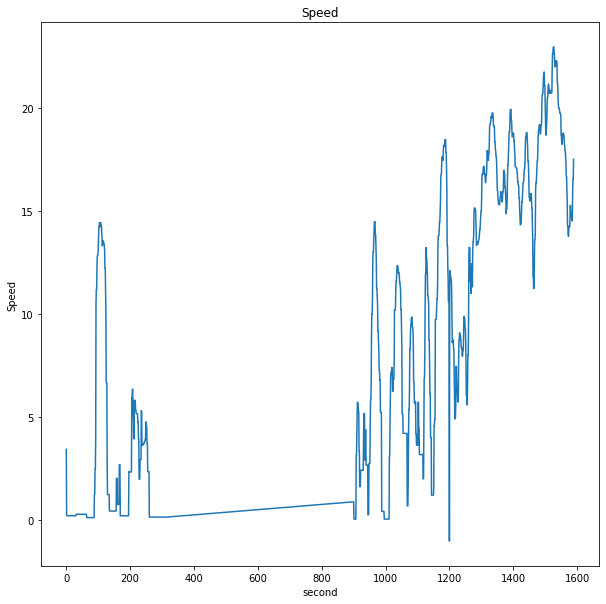

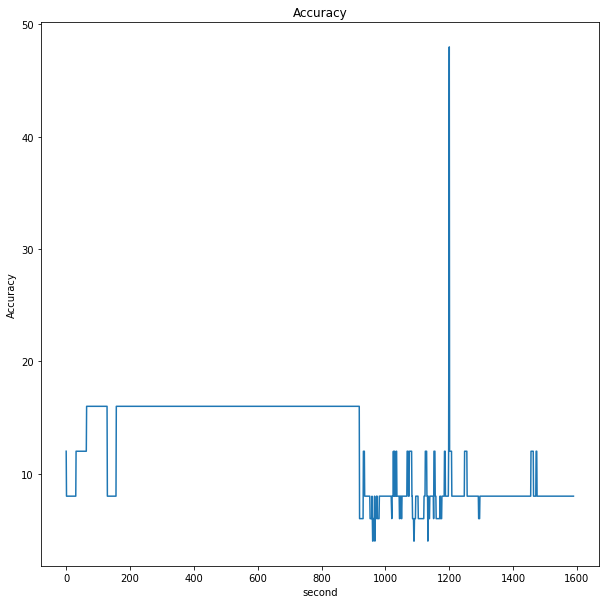

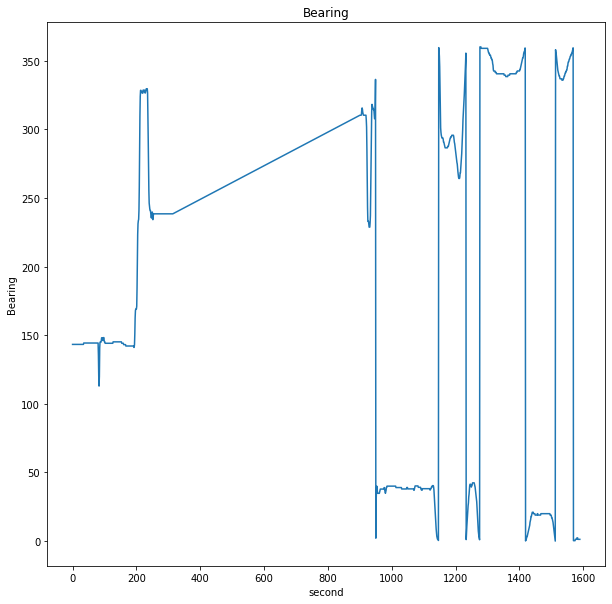

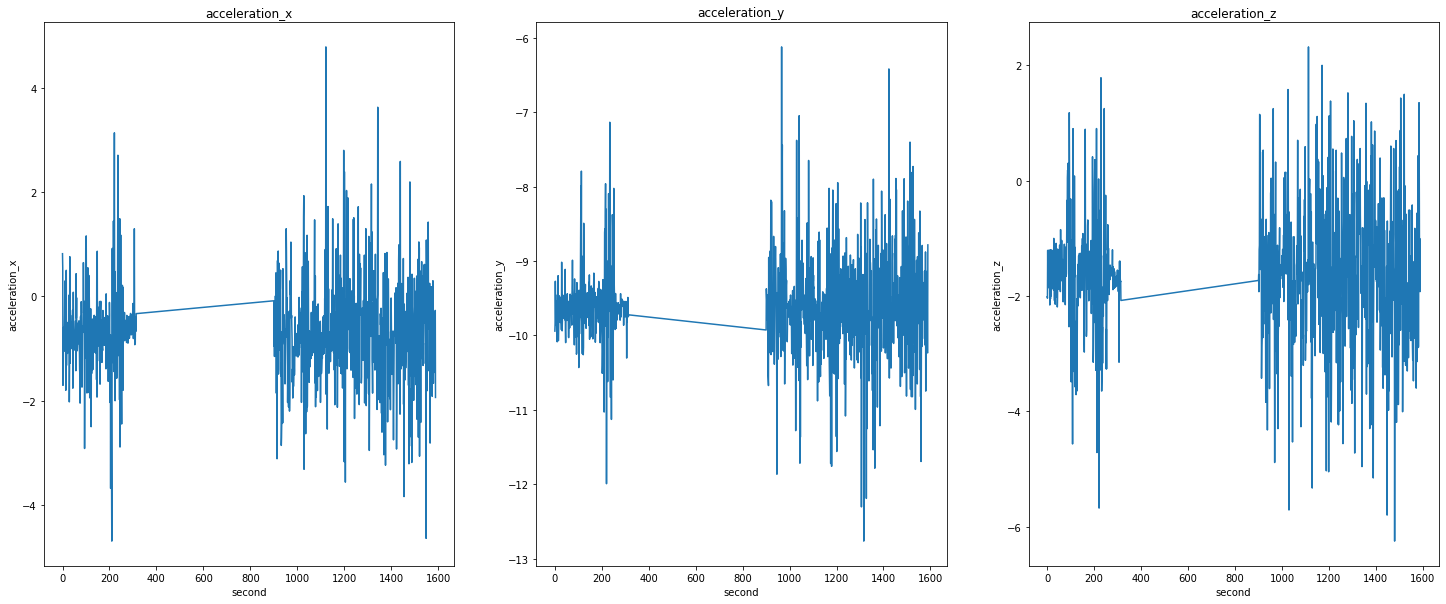

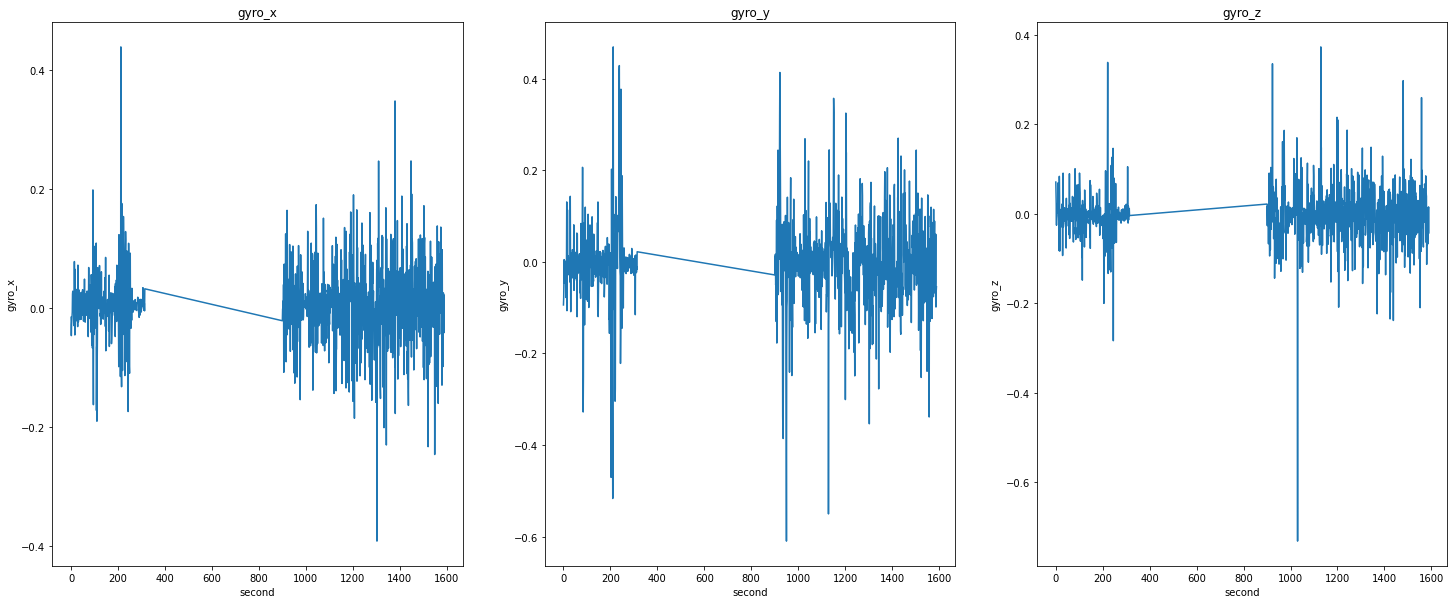

In [ ]:
# Looking at data for just 1 trip to see how it is like
# Taking a safe trip
one_trip_data = data[data['bookingID'] == 0]
display(one_trip_data)
display(one_trip_data.describe())

one_trip_data['second'].values

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x='second', y='Speed', data=one_trip_data, ax=ax)
ax.set_title('Speed')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x='second', y='Accuracy', data=one_trip_data, ax=ax)
ax.set_title('Accuracy')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x='second', y='Bearing', data=one_trip_data, ax=ax)
ax.set_title('Bearing')

accs = ['acceleration_x', 'acceleration_y', 'acceleration_z']
gyros = ['gyro_x', 'gyro_y', 'gyro_z']

fig, ax = plt.subplots(1, 3, figsize=(25, 10))
for acc, axes in zip(accs, ax):
  sns.lineplot(x='second', y=acc, data=one_trip_data, ax=axes)
  axes.set_title(acc)

fig, ax = plt.subplots(1, 3, figsize=(25, 10))
for gyro, axes in zip(gyros, ax):
  sns.lineplot(x='second', y=gyro, data=one_trip_data, ax=axes)
  axes.set_title(gyro)
  

# Few peculair things
# The seconds don't match up 1003 data points -> 1589 second? Some are missing

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
1004,1,4.0,252.0,-1.394632,10.174141,-2.503770,0.016127,0.212284,-0.039776,0.0,4.756427,1
1005,1,4.0,236.0,-0.840489,8.749026,-3.274607,0.037472,0.134862,-0.011083,1.0,4.937211,1
1006,1,4.0,228.0,-1.944456,8.989030,-2.978358,-0.024487,0.102224,-0.014870,2.0,5.544210,1
1007,1,4.0,222.0,-0.820675,9.282243,-2.126961,0.007522,0.089431,0.006004,3.0,6.564030,1
1008,1,4.0,216.0,-1.020284,9.382215,-2.618797,-0.019007,0.002409,-0.014382,4.0,7.358976,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1850,1,4.0,118.0,-0.978453,9.906622,-1.957212,-0.043947,0.069429,-0.014242,1030.0,9.938708,1
1851,1,4.0,112.0,-0.499344,10.274085,-2.085886,0.042970,0.124878,0.011746,1031.0,9.801586,1
1852,1,4.0,107.0,-0.969680,9.218988,-3.657564,-0.069743,-0.015900,0.004119,1032.0,9.683063,1
1853,1,4.0,105.0,-0.984084,9.502673,-2.788086,-0.005690,0.025604,-0.022637,1033.0,10.567403,1


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
count,851.0,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.0
mean,1.0,3.718763,124.198590,-0.525406,9.532086,-2.198999,-0.002467,-0.007540,0.000405,581.175088,7.881588,1.0
std,0.0,0.597933,89.861236,0.744157,0.533915,0.854271,0.027740,0.091699,0.033838,289.339367,7.059362,0.0
min,1.0,3.000000,0.000000,-5.352994,6.623425,-5.355455,-0.125367,-0.678183,-0.121265,0.000000,-1.000000,1.0
25%,1.0,3.000000,50.000000,-0.841121,9.277177,-2.583200,-0.015673,-0.033894,-0.014896,392.500000,0.000000,1.0
50%,1.0,3.900000,110.000000,-0.563126,9.537963,-2.175822,-0.001518,-0.003491,-0.000384,607.000000,6.904588,1.0
75%,1.0,4.000000,208.000000,-0.229374,9.796757,-1.819244,0.008744,0.022907,0.013334,819.500000,13.747929,1.0
max,1.0,7.709000,337.000000,3.813341,12.536156,1.481293,0.126536,0.470837,0.235131,1034.000000,21.882141,1.0


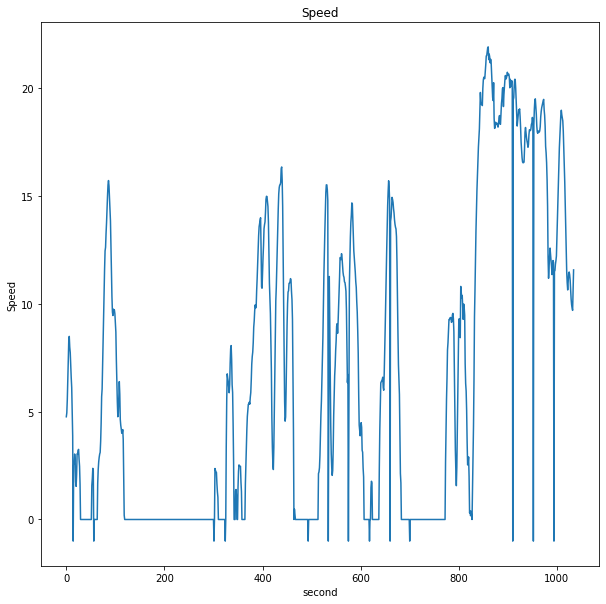

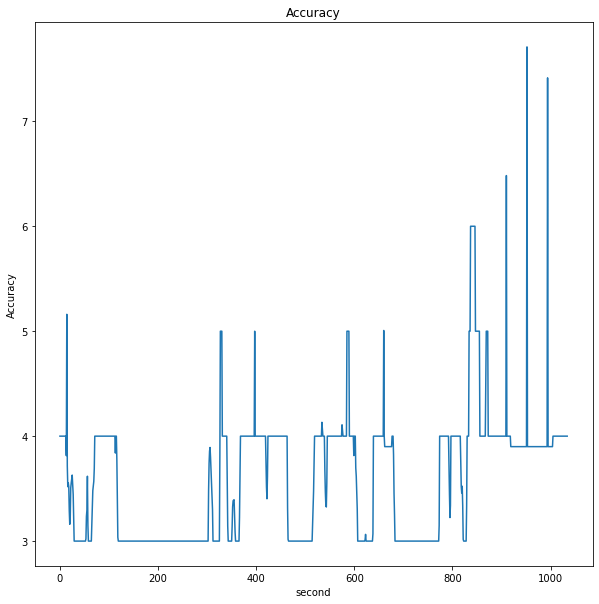

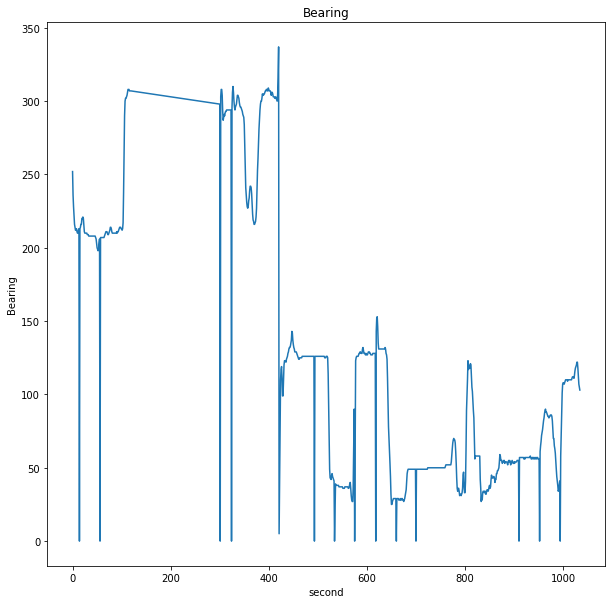

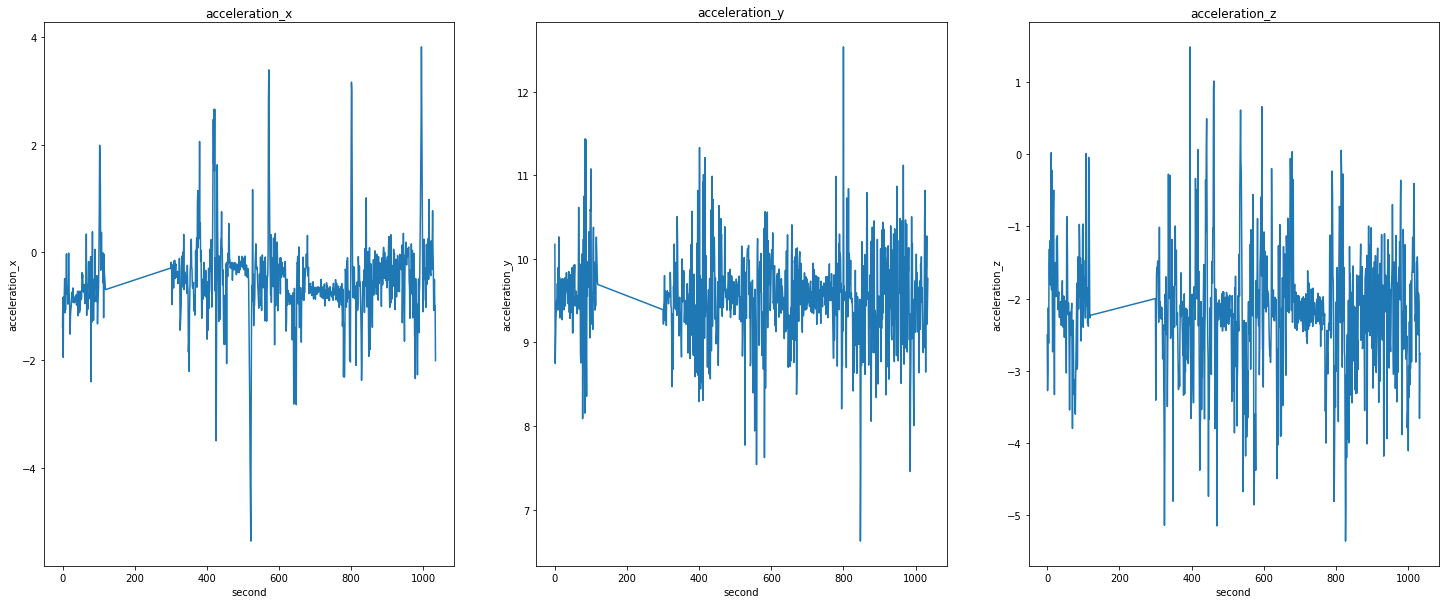

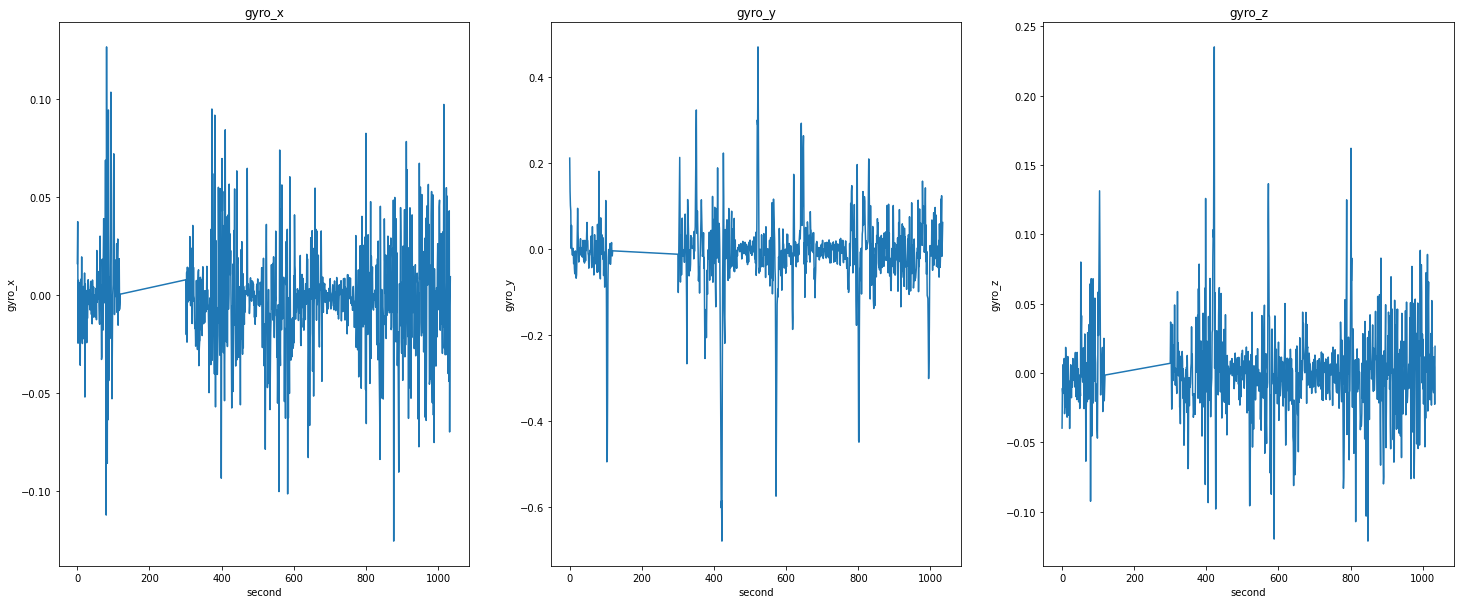

In [ ]:
# Looking at data for just 1 trip to see how it is like
# Taking a dangerous trip
one_trip_data = data[data['bookingID'] == 1]
display(one_trip_data)
display(one_trip_data.describe())

one_trip_data['second'].values

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x='second', y='Speed', data=one_trip_data, ax=ax)
ax.set_title('Speed')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x='second', y='Accuracy', data=one_trip_data, ax=ax)
ax.set_title('Accuracy')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x='second', y='Bearing', data=one_trip_data, ax=ax)
ax.set_title('Bearing')

accs = ['acceleration_x', 'acceleration_y', 'acceleration_z']
gyros = ['gyro_x', 'gyro_y', 'gyro_z']

fig, ax = plt.subplots(1, 3, figsize=(25, 10))
for acc, axes in zip(accs, ax):
  sns.lineplot(x='second', y=acc, data=one_trip_data, ax=axes)
  axes.set_title(acc)

fig, ax = plt.subplots(1, 3, figsize=(25, 10))
for gyro, axes in zip(gyros, ax):
  sns.lineplot(x='second', y=gyro, data=one_trip_data, ax=axes)
  axes.set_title(gyro)
  

# Comparing the 2 trips at an eye level
# acceleration seems to be reversed, maybe abs is a better option? (Prob need to recenter)
# Depending on the sign, the values of acc might be flipped, this could be very bad for tradditional models


In [ ]:
a = data.groupby(['bookingID'])['label'].max().value_counts()
display(a)
a[0] / (a[0] + a[1]) # 75% are 0

0    14999
1     4983
Name: label, dtype: int64

0.750625563006706

# Base line modelling and experiments

In this section we will be trying to establish a baseline for this problem.  
In particular we are interested in:
1. Is the problem a high variance or bias problem
2. How does the problem fairs using conventional approaches
3. What kind of performance can we be expecting, and what is the performance to beat.

For reason later on about why deep learning methods are hard for this kind of data, we will be sticking to using statistical features from the data to form a classical machine learning classification problem.

## Explaining metrics used and why

For our main metric used to compare models, I will be using the weighted F1 score.
This is mainly as with an unbalanced dataset (3/1 for the labels distribution), this will have an effect on both the accuracy and auc-roc to be used as a metric.  

In analysis on the experiments later on and maybe at the end however, we will be looking at the whole range of metrics to check on the model and properly evaluate its performance.  
But when deciding on which models are better and which methods we decided to experiment on more with will depend on the weighted f1 score.  

~~You could call the weight f1 score our single point of metric for model comparision.~~

We are changing to comparing f1 scores of the dangerous class (To prioritise the model accuracy on predicting dangerous trip) while also making sure its f1 score is still good for predicting the non-dangerous trips.



References:
- [ROC-AUC vs F1](https://stats.stackexchange.com/questions/210700/how-to-choose-between-roc-auc-and-f1-score)

## Setting up for the experiments

We need to process the data and get the statistical features for the classical ML models

We also need the helper functions to run the experiments for us

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, log_loss, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
exp_data = data
exp_data = exp_data.groupby(['bookingID'])[['Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'Speed']].agg(['mean', 'max', 'min']).reset_index()
exp_data.columns = ['_'.join(col).strip() for col in exp_data.columns.values]
exp_data = exp_data.drop(['bookingID_'], axis=1)
exp_data['label'] = data.groupby(['bookingID'])['label'].max().values
exp_data

,Accuracy_mean,Accuracy_max,Accuracy_min,Bearing_mean,Bearing_max,Bearing_min,acceleration_x_mean,acceleration_x_max,acceleration_x_min,acceleration_y_mean,acceleration_y_max,acceleration_y_min,acceleration_z_mean,acceleration_z_max,acceleration_z_min,gyro_x_mean,gyro_x_max,gyro_x_min,gyro_y_mean,gyro_y_max,gyro_y_min,gyro_z_mean,gyro_z_max,gyro_z_min,Speed_mean,Speed_max,Speed_min,label
0,10.165339,48.000,4.000,176.526099,359.979767,0.037464,-0.711264,4.782614,-4.692294,-9.613822,-6.119916,-12.764703,-1.619658,2.318857,-6.251807,0.003328,0.438371,-0.392537,-0.006118,0.469724,-0.609930,-0.004188,0.372807,-0.731892,8.994822,22.946083,-1.0,0
1,3.718763,7.709,3.000,124.198590,337.000000,0.000000,-0.525406,3.813341,-5.352994,9.532086,12.536156,6.623425,-2.198999,1.481293,-5.355455,-0.002467,0.126536,-0.125367,-0.007540,0.470837,-0.678183,0.000405,0.235131,-0.121265,7.881588,21.882141,-1.0,1
2,3.930626,8.000,3.000,173.794872,354.000000,1.000000,0.306786,1.956122,-2.971295,9.843183,13.333716,7.941810,0.139347,2.312870,-3.282551,0.006458,0.282162,-0.155218,-0.012861,0.431695,-0.462000,0.002597,0.255884,-0.125907,3.157213,9.360483,0.0,1
3,10.000000,10.000,10.000,151.807013,353.855377,2.271227,-0.365117,2.019635,-2.866458,-9.406439,-7.064984,-18.847833,-2.613639,0.296381,-9.374869,-0.022884,0.438732,-0.420507,0.023232,0.652628,-0.506531,-0.000376,0.505220,-0.348189,6.150996,19.780001,0.0,1
4,4.586721,12.000,3.000,197.812785,359.000000,0.000000,0.490616,5.593026,-4.352792,9.538043,13.249917,6.469330,2.355059,7.977724,-2.140482,0.003877,0.362202,-0.253551,0.000436,0.532123,-0.621802,0.002930,0.364534,-0.348345,4.628921,16.394695,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4.012152,43.317,3.000,169.904096,359.000000,0.000000,0.094130,11.296188,-15.993755,1.860878,39.845520,-34.944440,9.668742,64.904000,-24.088799,0.006799,2.139516,-1.905634,-0.008030,0.996193,-1.425123,-0.003830,1.958844,-2.603097,2.305969,6.294518,-1.0,1
19996,11.938692,25.000,4.000,179.182557,358.273376,10.027151,0.625696,3.709991,-3.379367,-8.680648,-6.295920,-11.460449,-4.512526,-1.559662,-7.695428,-0.016472,0.291135,-0.641901,0.006266,0.477245,-0.404243,-0.001241,0.233631,-0.496440,7.611645,24.059151,0.0,1
19997,9.412141,13.936,5.953,198.738462,359.000000,0.000000,-0.208879,2.272842,-4.727799,9.072497,11.238205,7.637329,3.319529,6.736664,0.272308,0.000408,0.122772,-0.172302,0.000600,0.489258,-0.683594,0.001489,0.284973,-0.252991,12.718705,26.340000,0.0,1
19998,5.401185,48.000,3.000,204.802228,359.000000,0.000000,0.669512,4.637710,-3.550709,8.896987,12.165310,5.542746,3.759712,9.347249,0.993624,0.003282,0.652905,-0.696496,-0.000685,3.940942,-1.048605,-0.000242,0.929654,-0.521151,6.245733,19.287226,-1.0,1


In [ ]:
# Defining the function to run this test and get the plots
def corr_test(model_algo, data, label):
    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(data.drop([label], axis=1), data[label], test_size=0.2)
    corr = data.corr()[label].sort_values(ascending=False).index
    corr = list(corr)
    corr.pop(0)
    # Define the arr to store the results
    train_err = []
    test_err = []

    train_acc = []
    test_acc = []

    train_f1 = []
    test_f1 = []

    train_roc_auc = []
    test_roc_auc = []
    # Main loop to progressively add features based on corr
    for i in range(len(corr)):
        features = corr[:i+1]
        model = Pipeline([('scaler', StandardScaler()), ('model', model_algo())])
        model.fit(x_train[features], y_train)
        train_preds = model.predict(x_train[features])
        test_preds = model.predict(x_test[features])

        train_err.append(log_loss(y_train, train_preds))
        test_err.append(log_loss(y_test, test_preds))

        train_acc.append(accuracy_score(y_train, train_preds))
        test_acc.append(accuracy_score(y_test, test_preds))

        train_f1.append(f1_score(y_train, train_preds))
        test_f1.append(f1_score(y_test, test_preds))

        train_roc_auc.append(roc_auc_score(y_train, train_preds))
        test_roc_auc.append(roc_auc_score(y_test, test_preds))
    # Merging them into a single df    
    eval_df = [train_err, test_err, train_acc, test_acc, train_f1, test_f1, train_roc_auc, test_roc_auc]
    eval_df = np.array(eval_df)
    eval_df = eval_df.T
    eval_df = pd.DataFrame(eval_df, columns=['train_err', 'test_err', 'train_acc', 'test_acc', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc'])
    eval_df['x_ax'] = range(1, len(corr)+1)
    display(eval_df)
    # Plotting the values out
    for i, (train_str, test_str) in enumerate(zip(['train_err', 'train_acc', 'train_f1', 'train_roc_auc'], ['test_err', 'test_acc', 'test_f1', 'test_roc_auc'])):
      fig, ax = plt.subplots(1, 1, figsize=(10, 10))
      sns.lineplot(x='x_ax', y='value', hue='variable', data=pd.melt(eval_df[['x_ax', train_str, test_str]], ['x_ax']), ax=ax)



In [ ]:
# Defining the function to run this test and get the plots
def data_test(model_algo, data, label, prop=20):
    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(data.drop([label], axis=1), data[label], test_size=0.2)
    # Create the data splits
    splits = np.linspace(10, x_train.shape[0], prop, dtype=int)
    # Define the arr to store the results
    train_err = []
    test_err = []

    train_acc = []
    test_acc = []

    train_f1 = []
    test_f1 = []

    train_roc_auc = []
    test_roc_auc = []
    # Main loop to progressively add features based on corr
    for split in splits:
        x = x_train.head(split)
        y = y_train.head(split)
        model = Pipeline([('scaler', StandardScaler()), ('model', model_algo())])
        model.fit(x, y)
        train_preds = model.predict(x)
        test_preds = model.predict(x_test)

        train_err.append(log_loss(y, train_preds))
        test_err.append(log_loss(y_test, test_preds))

        train_acc.append(accuracy_score(y, train_preds))
        test_acc.append(accuracy_score(y_test, test_preds))

        train_f1.append(f1_score(y, train_preds))
        test_f1.append(f1_score(y_test, test_preds))

        train_roc_auc.append(roc_auc_score(y, train_preds))
        test_roc_auc.append(roc_auc_score(y_test, test_preds))
    # Merging them into a single df    
    eval_df = [train_err, test_err, train_acc, test_acc, train_f1, test_f1, train_roc_auc, test_roc_auc]
    eval_df = np.array(eval_df)
    eval_df = eval_df.T
    eval_df = pd.DataFrame(eval_df, columns=['train_err', 'test_err', 'train_acc', 'test_acc', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc'])
    eval_df['x_ax'] = range(1, len(splits)+1)
    display(eval_df)
    # Plotting the values out
    for i, (train_str, test_str) in enumerate(zip(['train_err', 'train_acc', 'train_f1', 'train_roc_auc'], ['test_err', 'test_acc', 'test_f1', 'test_roc_auc'])):
      fig, ax = plt.subplots(1, 1, figsize=(10, 10))
      sns.lineplot(x='x_ax', y='value', hue='variable', data=pd.melt(eval_df[['x_ax', train_str, test_str]], ['x_ax']), ax=ax)

In [ ]:
def simple_train(model_algo, data, label):
  # Split the data into train and test sets
  x_train, x_test, y_train, y_test = train_test_split(data.drop([label], axis=1), data[label], test_size=0.2)
  model = Pipeline([('scale', StandardScaler()), ('model', model_algo())])
  model.fit(x_train, y_train)

  test_preds = model.predict(x_test)
  
  # Classification report
  f1 = f1_score(y_test, test_preds)
  cr = classification_report(y_test, test_preds)
  cm = confusion_matrix(y_test, test_preds)
  print(f1)
  print(cr)
  print(cm)
  
  sns.heatmap(cm, annot=True, cmap='copper')
  plt.show()
  return x_train, x_test, y_train, y_test, model

## Is the problem a high variance or bias problem?

The reason for trying to find this out, is to guide our decision making for either making the model more complex or dealing with the data in a different way.  



In [ ]:
exp_data.isnull().sum()

Accuracy_mean          0
Accuracy_max           0
Accuracy_min           0
Bearing_mean           0
Bearing_max            0
Bearing_min            0
acceleration_x_mean    0
acceleration_x_max     0
acceleration_x_min     0
acceleration_y_mean    0
acceleration_y_max     0
acceleration_y_min     0
acceleration_z_mean    0
acceleration_z_max     0
acceleration_z_min     0
gyro_x_mean            0
gyro_x_max             0
gyro_x_min             0
gyro_y_mean            0
gyro_y_max             0
gyro_y_min             0
gyro_z_mean            0
gyro_z_max             0
gyro_z_min             0
Speed_mean             0
Speed_max              0
Speed_min              0
label                  0
dtype: int64

,train_err,test_err,train_acc,test_acc,train_f1,test_f1,train_roc_auc,test_roc_auc,x_ax
0,8.431053,8.312816,0.755896,0.759319,0.088744,0.083810,0.520018,0.518140,1
1,8.294928,8.260968,0.759837,0.760821,0.114418,0.092979,0.527472,0.520857,2
2,8.288448,8.252329,0.760025,0.761071,0.126594,0.109972,0.530092,0.524467,3
3,8.288447,8.217763,0.760025,0.762072,0.125000,0.107042,0.529759,0.524441,4
4,8.262517,8.183196,0.760776,0.763072,0.112761,0.093780,0.527682,0.522348,5
5,8.279803,8.183196,0.760275,0.763072,0.112141,0.095511,0.527265,0.522693,6
6,8.279803,8.183196,0.760275,0.763072,0.112141,0.095511,0.527265,0.522693,7
7,8.279805,8.209122,0.760275,0.762322,0.126709,0.107143,0.530259,0.524607,8
8,8.279805,8.209122,0.760275,0.762322,0.126709,0.107143,0.530259,0.524607,9
9,8.277644,8.235046,0.760338,0.761571,0.126738,0.105164,0.530301,0.523765,10


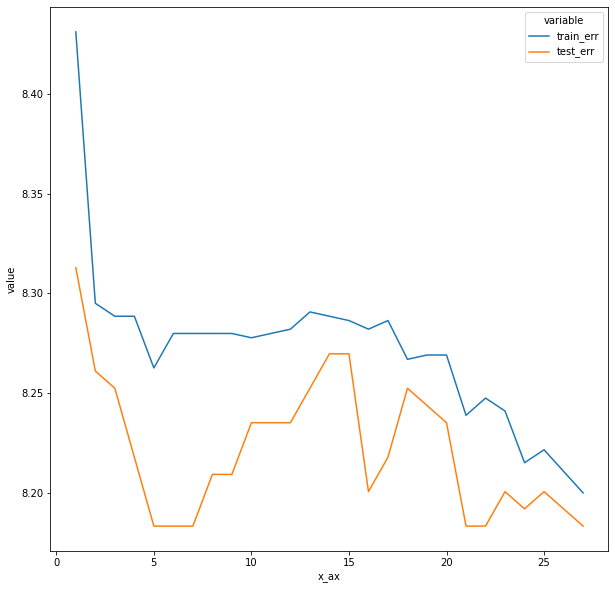

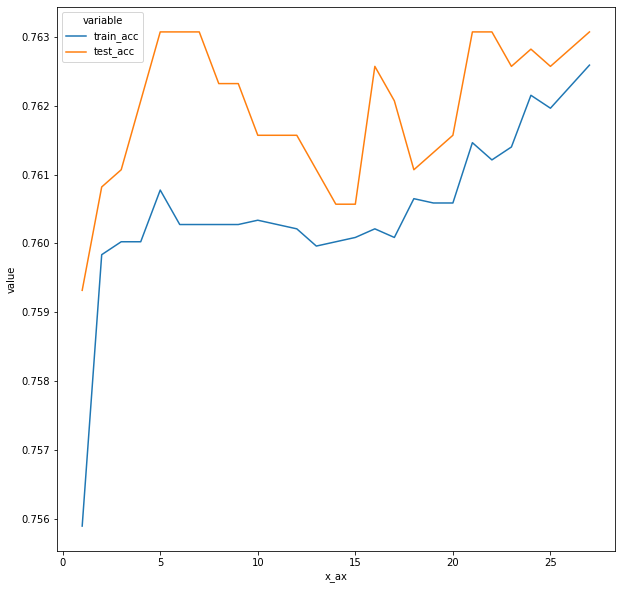

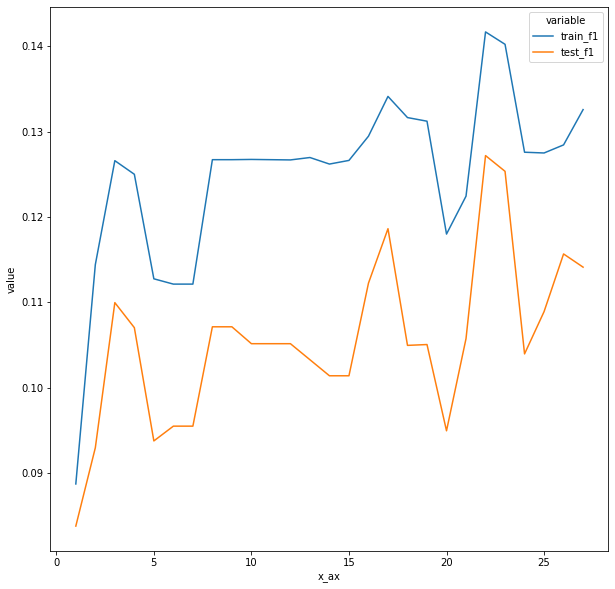

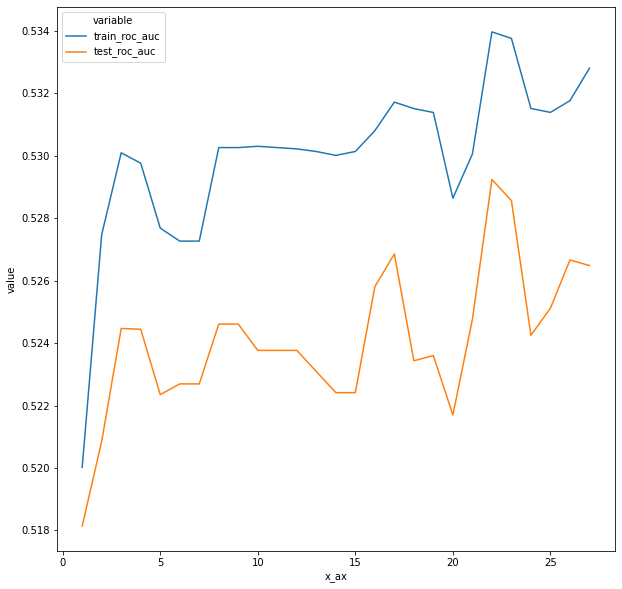

In [ ]:
corr_test(LogisticRegressionCV, exp_data, 'label')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,train_err,test_err,train_acc,test_acc,train_f1,test_f1,train_roc_auc,test_roc_auc,x_ax
0,13.815830,26.025571,0.600000,0.24650,0.750000,0.395507,0.500000,0.500000,1
1,8.076649,8.254782,0.766157,0.76100,0.276364,0.174439,0.573662,0.539439,2
2,8.119574,8.142521,0.764914,0.76425,0.111607,0.117867,0.526991,0.528629,3
3,8.164459,8.125252,0.763615,0.76475,0.117820,0.127896,0.528333,0.531008,4
4,8.266392,8.254770,0.760664,0.76100,0.092135,0.082534,0.522296,0.519649,5
5,8.157609,8.159791,0.763813,0.76375,0.118584,0.124189,0.528717,0.529662,6
6,8.213120,8.133887,0.762206,0.76450,0.135155,0.127778,0.533140,0.530843,7
7,8.141581,8.116617,0.764277,0.76500,0.126805,0.131238,0.530547,0.531857,8
8,8.155706,8.116618,0.763868,0.76500,0.136659,0.132841,0.533068,0.532198,9
9,8.142850,8.116617,0.764241,0.76500,0.128655,0.128015,0.530987,0.531174,10


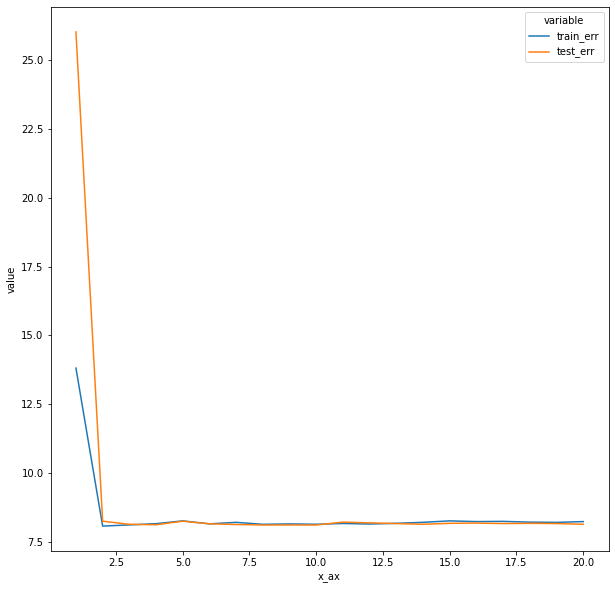

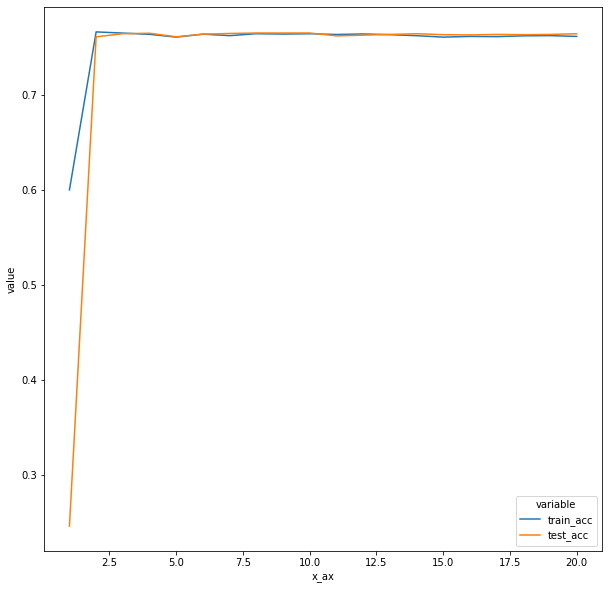

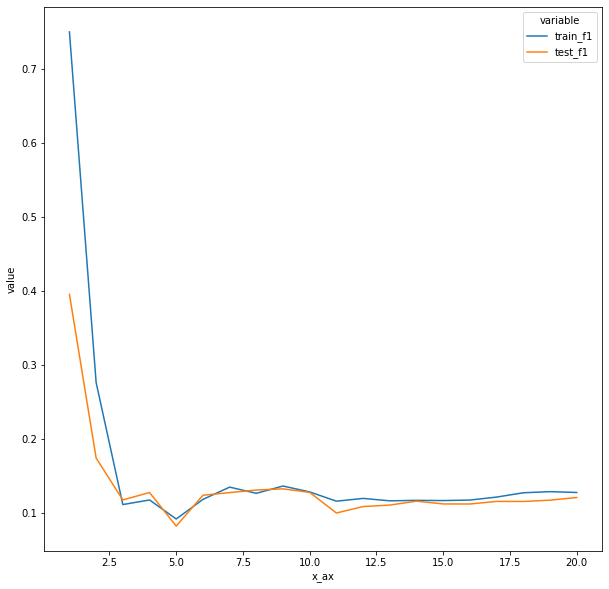

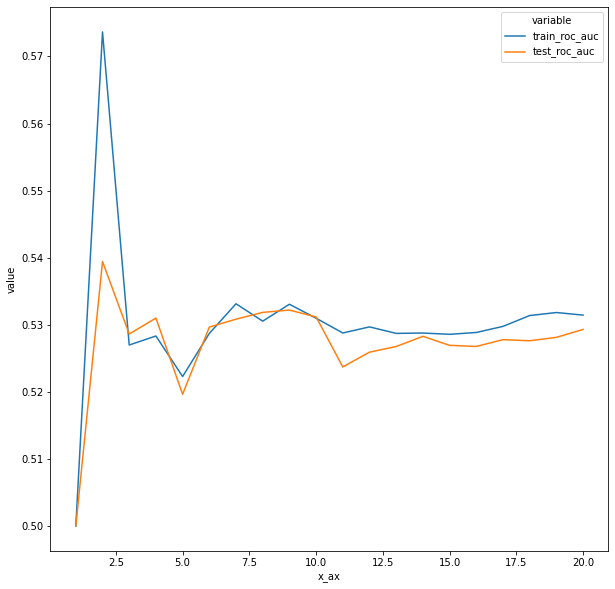

In [ ]:
data_test(LogisticRegressionCV, exp_data, 'label', 20)

0.13308341143392688
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      3021
           1       0.81      0.07      0.13       979

    accuracy                           0.77      4000
   macro avg       0.79      0.53      0.50      4000
weighted avg       0.78      0.77      0.69      4000

[[3004   17]
 [ 908   71]]


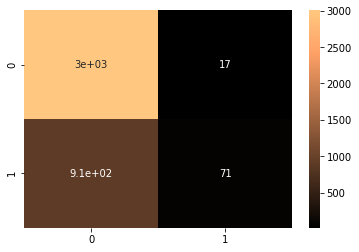

In [ ]:
x_train, x_test, y_train, y_test, model = simple_train(LogisticRegressionCV, exp_data, 'label')

From the experiments we can see that conventional approaches are really bad.  
The baseline to beat is an f1 score (For the dangerous class) of 0.17 and aucroc of 0.5.   
Based on the confusion matrix, we can also see that the class imbalance is causing the model to preform really badly, not being able to correctly classify dangerous trips

Looking at experiment 1, comparing the effect of introducing more features by correlation, we can see that the f1 score for the train is higher compared to the test. (Although, the scale is quite small, but the trendis that the train f1 is higher) This suggests that the model is overfitting on the dataset. Moreover, based on the confusion matrix we can see the reason for this is due to the misclassification of the dangerous driving class.

## How does the problem fairs using conventional approaches?

We will be using a few ML models, namely:
1. Logistical Regression
2. GBC
3. RandomForest

This is to get a better sensing of how the dataset work in these different models

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

0.13715277777777776
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      2968
           1       0.66      0.08      0.14      1032

    accuracy                           0.75      4000
   macro avg       0.71      0.53      0.50      4000
weighted avg       0.73      0.75      0.67      4000

[[2927   41]
 [ 953   79]]


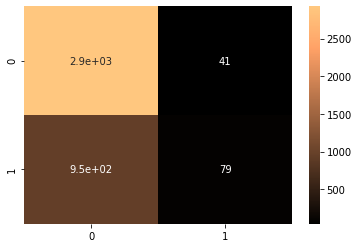

In [ ]:
_ = simple_train(RandomForestClassifier, exp_data, 'label')

0.15875754961173424
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      2962
           1       0.76      0.09      0.16      1038

    accuracy                           0.76      4000
   macro avg       0.76      0.54      0.51      4000
weighted avg       0.76      0.76      0.68      4000

[[2933   29]
 [ 946   92]]


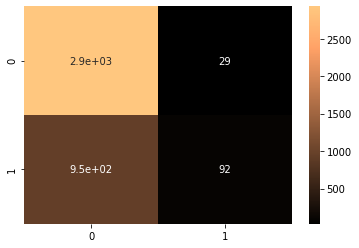

In [ ]:
_ = simple_train(GradientBoostingClassifier, exp_data, 'label')

Well no surprise here, GBC did the best among the models

But still, these model's performance are quite subpar.  
Thus we will try and improve them later on

# Moving on to more EDA and data anaylsis

In this section, more EDA will be done, as well as feature engineering and processing of the data.

But first we will be looking at how the distributions differ for dangerous and non-dangerous trips.

## Looking at statistical features first

For this we will actually be using the calculated experimental data used above

In [ ]:
exp_data

,Accuracy_mean,Accuracy_max,Accuracy_min,Bearing_mean,Bearing_max,Bearing_min,acceleration_x_mean,acceleration_x_max,acceleration_x_min,acceleration_y_mean,acceleration_y_max,acceleration_y_min,acceleration_z_mean,acceleration_z_max,acceleration_z_min,gyro_x_mean,gyro_x_max,gyro_x_min,gyro_y_mean,gyro_y_max,gyro_y_min,gyro_z_mean,gyro_z_max,gyro_z_min,Speed_mean,Speed_max,Speed_min,label
0,10.165339,48.000,4.000,176.526099,359.979767,0.037464,-0.711264,4.782614,-4.692294,-9.613822,-6.119916,-12.764703,-1.619658,2.318857,-6.251807,0.003328,0.438371,-0.392537,-0.006118,0.469724,-0.609930,-0.004188,0.372807,-0.731892,8.994822,22.946083,-1.0,0
1,3.718763,7.709,3.000,124.198590,337.000000,0.000000,-0.525406,3.813341,-5.352994,9.532086,12.536156,6.623425,-2.198999,1.481293,-5.355455,-0.002467,0.126536,-0.125367,-0.007540,0.470837,-0.678183,0.000405,0.235131,-0.121265,7.881588,21.882141,-1.0,1
2,3.930626,8.000,3.000,173.794872,354.000000,1.000000,0.306786,1.956122,-2.971295,9.843183,13.333716,7.941810,0.139347,2.312870,-3.282551,0.006458,0.282162,-0.155218,-0.012861,0.431695,-0.462000,0.002597,0.255884,-0.125907,3.157213,9.360483,0.0,1
3,10.000000,10.000,10.000,151.807013,353.855377,2.271227,-0.365117,2.019635,-2.866458,-9.406439,-7.064984,-18.847833,-2.613639,0.296381,-9.374869,-0.022884,0.438732,-0.420507,0.023232,0.652628,-0.506531,-0.000376,0.505220,-0.348189,6.150996,19.780001,0.0,1
4,4.586721,12.000,3.000,197.812785,359.000000,0.000000,0.490616,5.593026,-4.352792,9.538043,13.249917,6.469330,2.355059,7.977724,-2.140482,0.003877,0.362202,-0.253551,0.000436,0.532123,-0.621802,0.002930,0.364534,-0.348345,4.628921,16.394695,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4.012152,43.317,3.000,169.904096,359.000000,0.000000,0.094130,11.296188,-15.993755,1.860878,39.845520,-34.944440,9.668742,64.904000,-24.088799,0.006799,2.139516,-1.905634,-0.008030,0.996193,-1.425123,-0.003830,1.958844,-2.603097,2.305969,6.294518,-1.0,1
19996,11.938692,25.000,4.000,179.182557,358.273376,10.027151,0.625696,3.709991,-3.379367,-8.680648,-6.295920,-11.460449,-4.512526,-1.559662,-7.695428,-0.016472,0.291135,-0.641901,0.006266,0.477245,-0.404243,-0.001241,0.233631,-0.496440,7.611645,24.059151,0.0,1
19997,9.412141,13.936,5.953,198.738462,359.000000,0.000000,-0.208879,2.272842,-4.727799,9.072497,11.238205,7.637329,3.319529,6.736664,0.272308,0.000408,0.122772,-0.172302,0.000600,0.489258,-0.683594,0.001489,0.284973,-0.252991,12.718705,26.340000,0.0,1
19998,5.401185,48.000,3.000,204.802228,359.000000,0.000000,0.669512,4.637710,-3.550709,8.896987,12.165310,5.542746,3.759712,9.347249,0.993624,0.003282,0.652905,-0.696496,-0.000685,3.940942,-1.048605,-0.000242,0.929654,-0.521151,6.245733,19.287226,-1.0,1


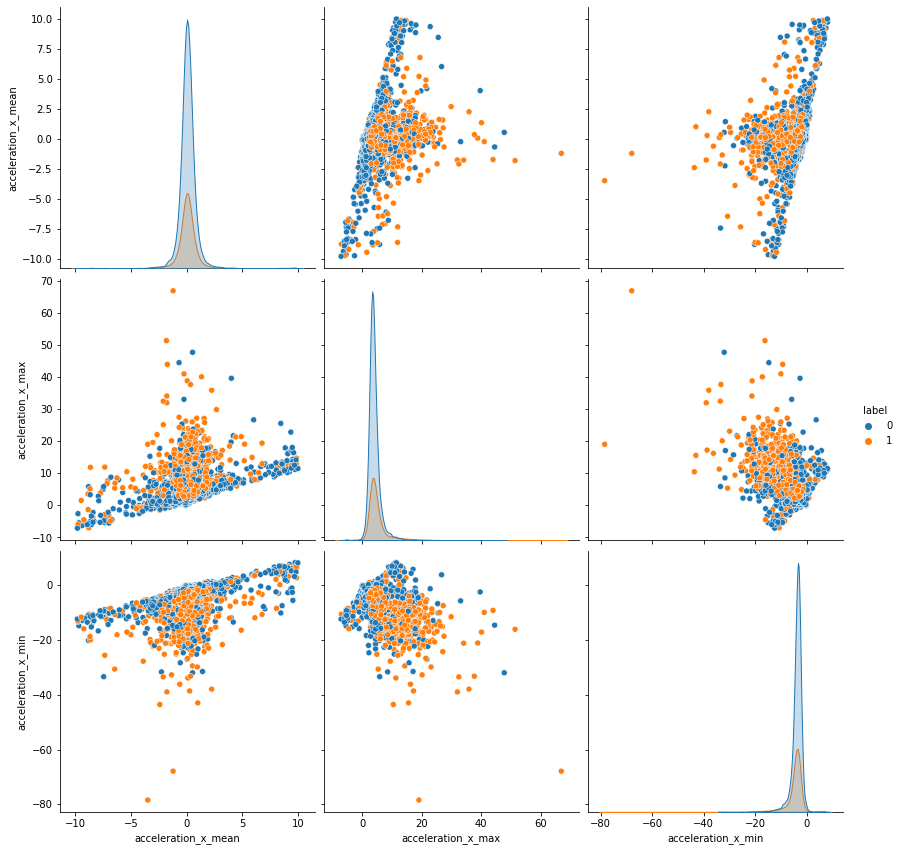

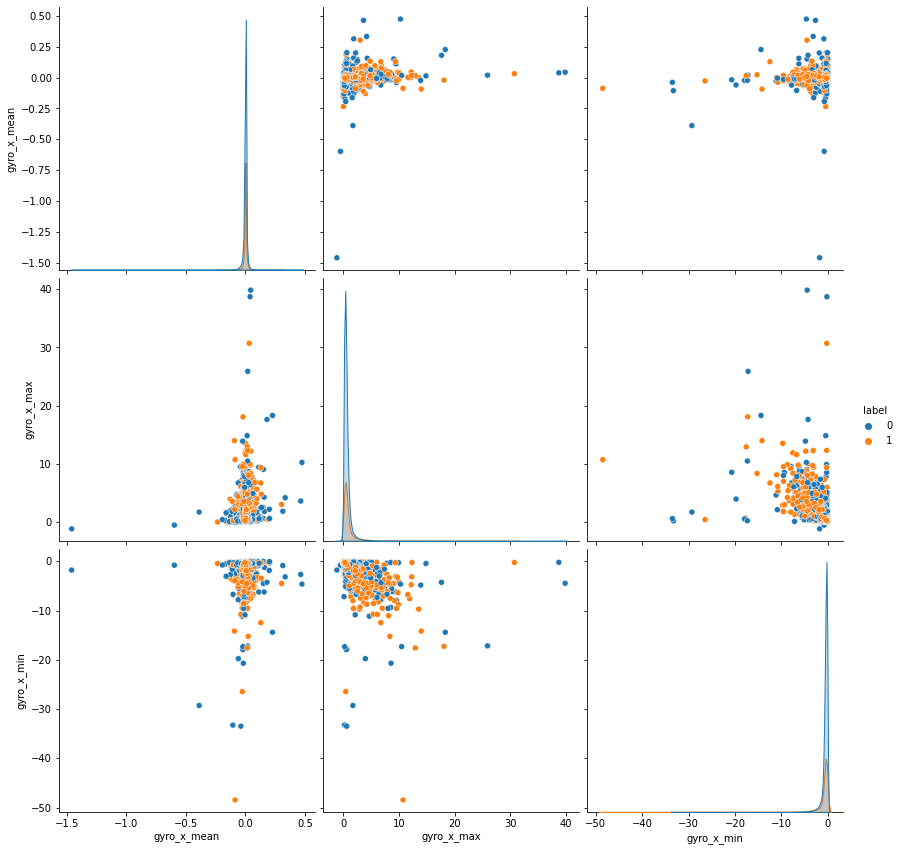

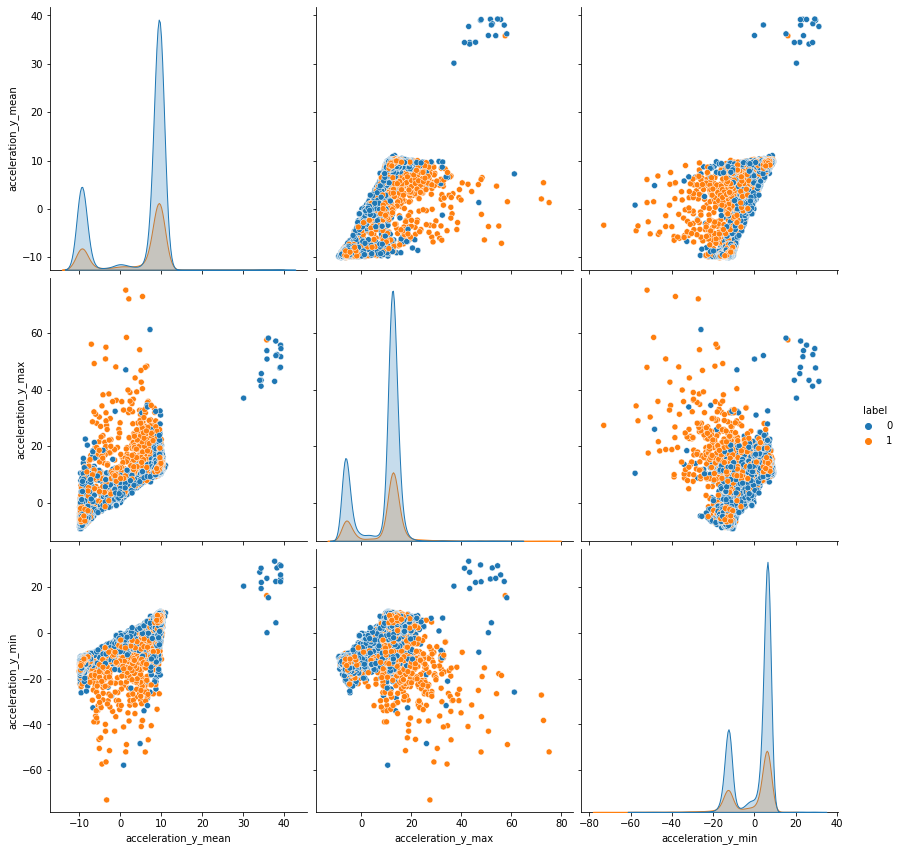

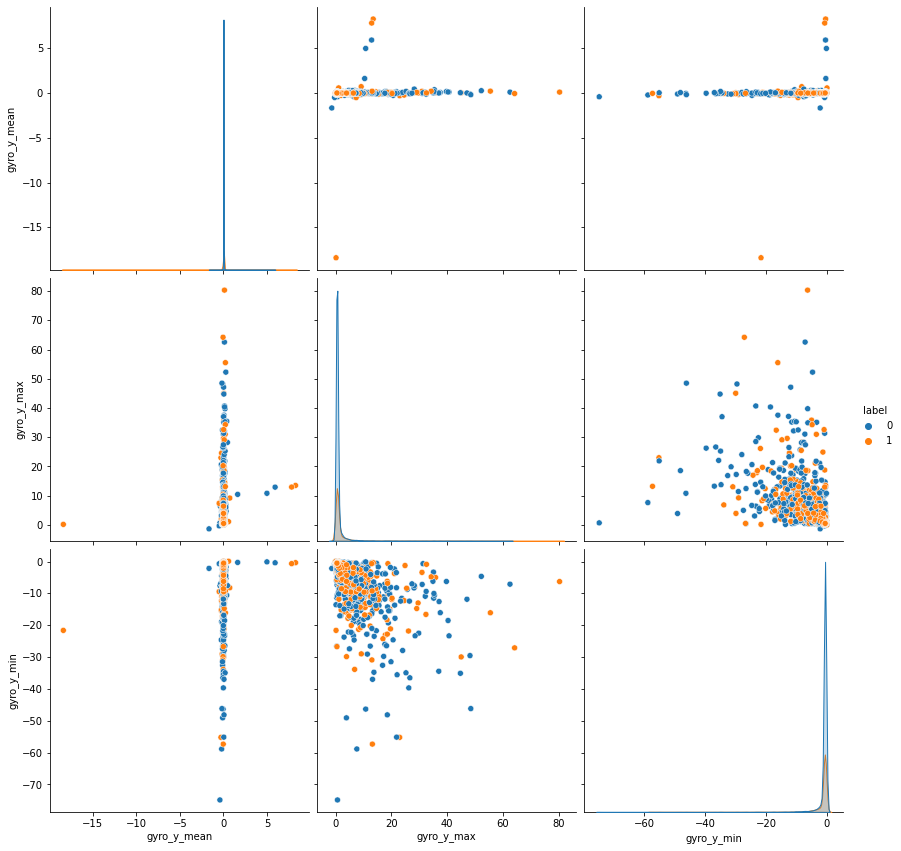

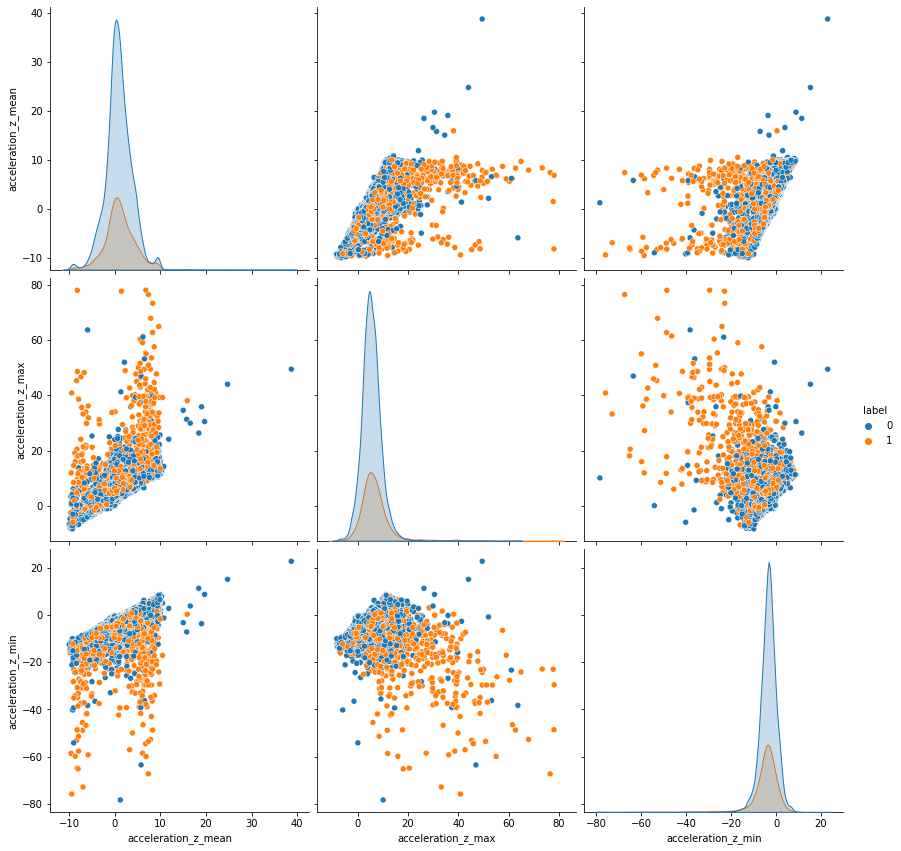

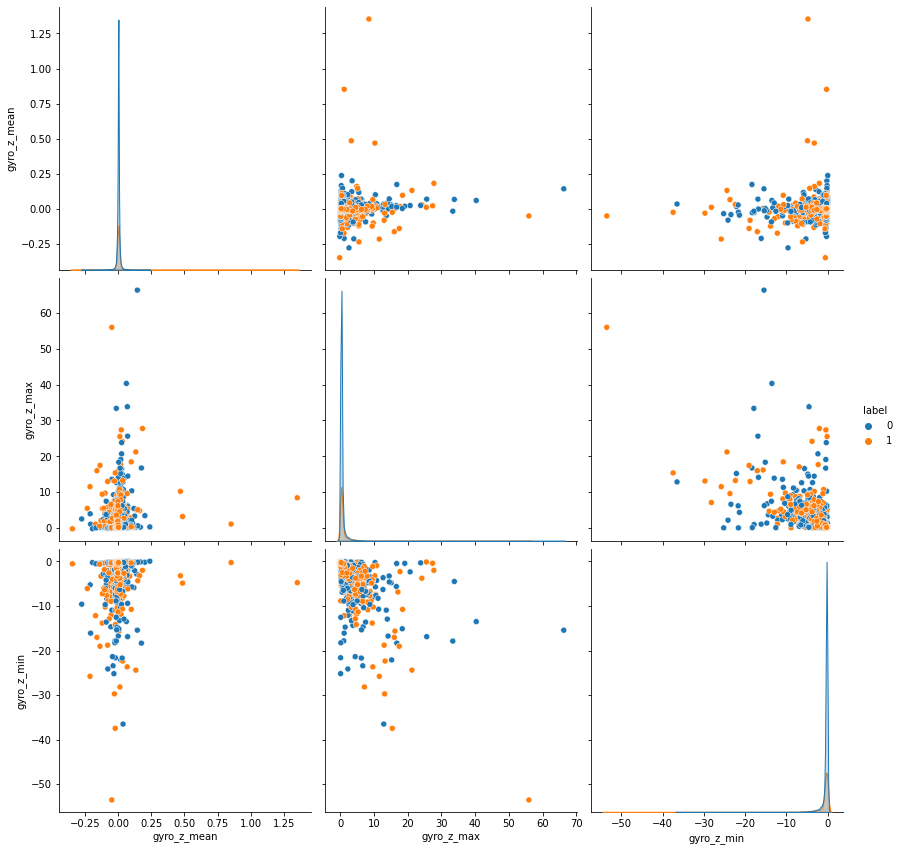

In [ ]:
for i in ['x', 'y', 'z']:
  sns.pairplot(exp_data[[f'acceleration_{i}_mean', f'acceleration_{i}_max', f'acceleration_{i}_min', 'label']], hue='label', height=4)
  plt.show()
  sns.pairplot(exp_data[[f'gyro_{i}_mean', f'gyro_{i}_max', f'gyro_{i}_min', 'label']], hue='label', height=4)

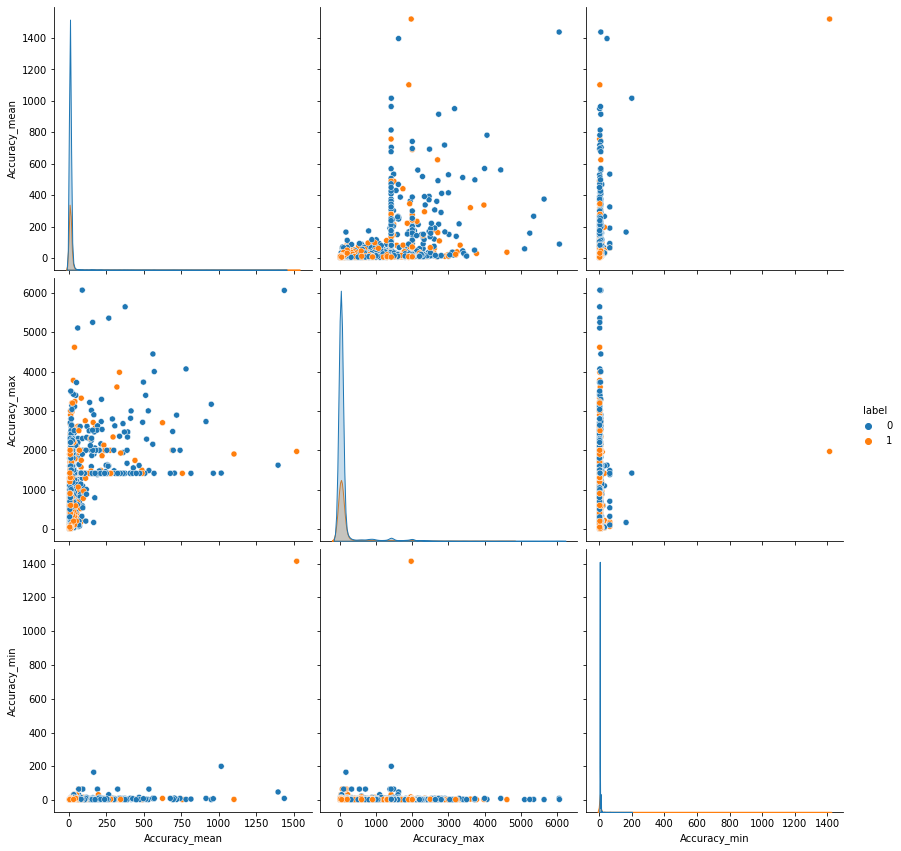

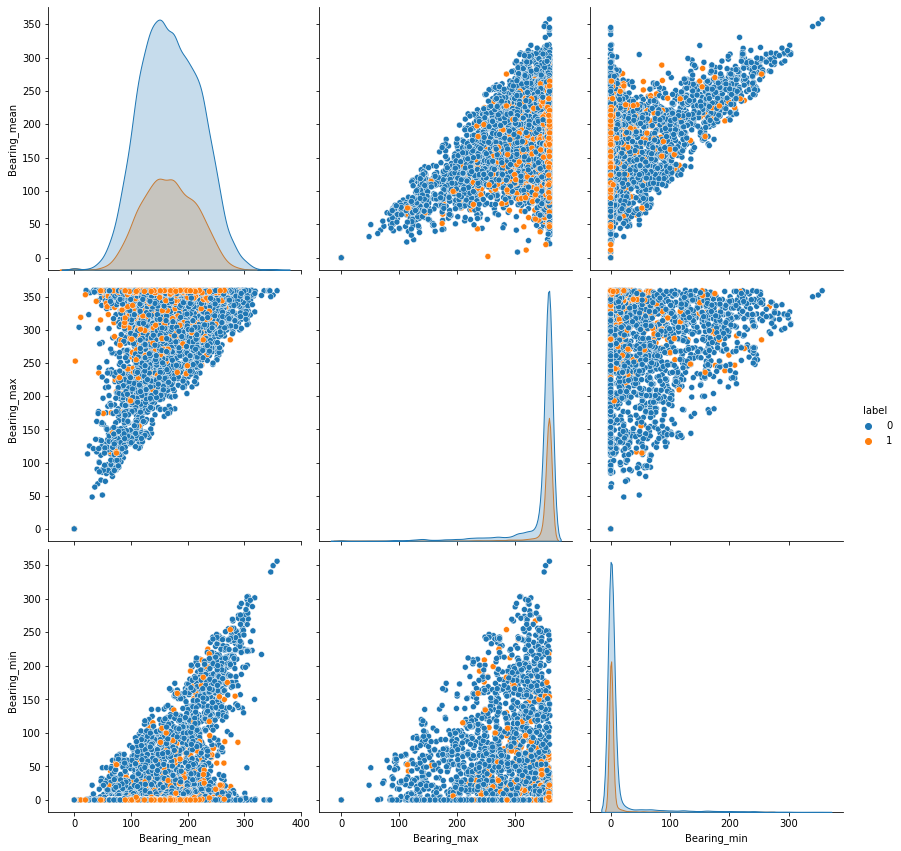

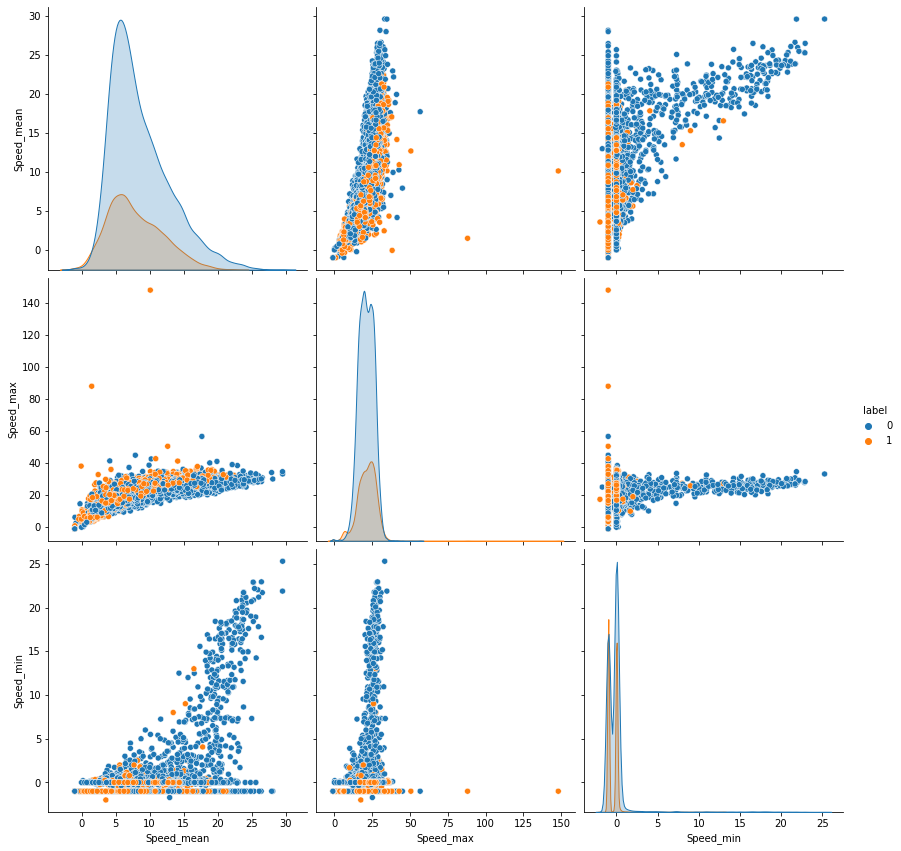

In [ ]:
for i in ['Accuracy', 'Bearing', 'Speed']:
  sns.pairplot(exp_data[[f'{i}_mean', f'{i}_max', f'{i}_min', 'label']], hue='label', height=4)
  plt.show()

From what it seems, between dangerous and non-dangerous trips, most of the statiscal features have the same distribution. The only real exception is the speed feature, where we can see a slight skew of dangerous trips having a high mean spead. (Even then we can't really classify or tell a trip is dangerous from this information)  

This relates back to our inital conclusion from the experiment that statistical features are not a good way to classify these trips. 

## Feature engineering and process

This section will go over the feature engineering and process for both the DL and classical ML methods we will try later on. 

In [ ]:
# Making copies to work on
dl_data = data
ml_data = data

First, based on the observation previously, it seems like the accerlation of x, y and z are not in the same direction all the time.
As such I would like to treat them as vectors in 3 dirs and combine them into 1 vec taking just the magnitude.
But before that, we also want to take a closer look at large outliers.

Furthermore, we can see previously that the values are distributed around 0, with negative values as well.  
Also it seems like for the x and z axis, they are usually noise, with the y acceleration contributing mainly to the car movement.

But using the combined magnitude of the vector, we can ignore this range of distribution around 0.
Because what we care more about is the change in the acceleration than the actual values.
This would also help both ML and DL model converge better.

We can then solve the issue of noise by taking the magnitude of just the y axis and using it as a feature as well.

In [ ]:
ml_data[[f'acceleration_{i}' for i in ['x', 'y', 'z']]].describe().apply(lambda x: x.apply('{0:.5f}'.format))

,acceleration_x,acceleration_y,acceleration_z
count,16154418.00000,16154418.00000,16154418.00000
mean,0.06931,4.46436,0.89273
std,1.42370,8.13282,3.25289
min,-78.41969,-72.99412,-78.44842
25%,-0.50782,-2.11399,-0.93377
50%,0.06160,9.08121,0.77409
75%,0.63538,9.70969,2.74907
max,66.87346,75.05589,78.05576


In [ ]:
# Looking more closely at the quantiles looking at 99 percent
display(ml_data[[f'acceleration_{i}' for i in ['x', 'y', 'z']]].quantile(0.999))
display(ml_data[[f'acceleration_{i}' for i in ['x', 'y', 'z']]].quantile(0.001))
# Looking at how many values outside this range
print(ml_data.shape[0] * (1- 0.999))

# q_999 = ml_data[[f'acceleration_{i}' for i in ['x', 'y', 'z']]].quantile(0.999).values
# q_001 = ml_data[[f'acceleration_{i}' for i in ['x', 'y', 'z']]].quantile(0.001).values

q_999 = ml_data[[f'acceleration_{i}' for i in ['x', 'y', 'z']]].quantile(0.99).values
q_001 = ml_data[[f'acceleration_{i}' for i in ['x', 'y', 'z']]].quantile(0.01).values
mask = None
for i, q999, q001 in zip(['x', 'y', 'z'], q_999, q_001):
  if mask is None:
    mask = ml_data[f'acceleration_{i}'] > q999
    mask = mask | (ml_data[f'acceleration_{i}'] < q001)
  else:
    mask = mask | (ml_data[f'acceleration_{i}'] > q999)
    mask = mask | (ml_data[f'acceleration_{i}'] < q001)

ml_data = ml_data[~mask]
ml_data

# Based of some back of the napkin calculations
# The fastest car accelerates at a rate of 100km in 2.3s -> 12m/s/s
# So some of these values still do not make sense but we will take the 99 percentile as the large outliers defintely do not make sense
# Could also be because of the accuracy

acceleration_x     9.765978
acceleration_y    18.820201
acceleration_z    13.302812
Name: 0.999, dtype: float64

acceleration_x    -9.401872
acceleration_y   -12.288668
acceleration_z   -10.617813
Name: 0.001, dtype: float64

16154.418000000014


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16154413,1709396983975,8.0,199.547104,-0.320905,-8.949738,-3.971979,-0.012879,0.015905,-0.007625,559.0,1.035811,1
16154414,1709396983975,8.0,199.547104,-0.418253,-8.929102,-3.950296,-0.006455,0.005278,-0.000082,560.0,1.035811,1
16154415,1709396983975,12.0,199.547104,-0.226697,-8.914597,-4.338940,0.044719,0.032351,-0.018600,561.0,0.302453,1
16154416,1709396983975,12.0,199.547104,-0.372943,-8.951382,-4.416550,0.053263,0.029213,-0.016357,562.0,0.302453,1


In [ ]:
# Creating the vector to look at the values first
ml_data['acc_vec'] = np.sqrt(ml_data['acceleration_x']**2 + ml_data['acceleration_y']**2 + ml_data['acceleration_z']**2)
ml_data['acc_y'] = np.sqrt(ml_data['acceleration_y']**2)

display(ml_data['acc_vec'].describe().apply(lambda x: format(x, 'f')))
display(ml_data['acc_y'].describe().apply(lambda x: format(x, 'f')))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count    15229957.000000
mean            9.794472
std             0.655549
min             0.005074
25%             9.534295
50%             9.805519
75%            10.091374
max            15.138242
Name: acc_vec, dtype: object

count    15229957.000000
mean            9.208206
std             1.185775
min             0.000000
25%             8.891119
50%             9.469357
75%             9.812635
max            11.399506
Name: acc_y, dtype: object

In [ ]:
ml_data

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,acc_vec,acc_y
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0,10.176551,9.941461
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0,10.059553,9.835590
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0,9.503762,9.270792
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0,9.830320,9.548032
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0,9.967466,9.853534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16154413,1709396983975,8.0,199.547104,-0.320905,-8.949738,-3.971979,-0.012879,0.015905,-0.007625,559.0,1.035811,1,9.796805,8.949738
16154414,1709396983975,8.0,199.547104,-0.418253,-8.929102,-3.950296,-0.006455,0.005278,-0.000082,560.0,1.035811,1,9.772852,8.929102
16154415,1709396983975,12.0,199.547104,-0.226697,-8.914597,-4.338940,0.044719,0.032351,-0.018600,561.0,0.302453,1,9.917047,8.914597
16154416,1709396983975,12.0,199.547104,-0.372943,-8.951382,-4.416550,0.053263,0.029213,-0.016357,562.0,0.302453,1,9.988606,8.951382


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,acc_vec,acc_y
16152907,1709396983971,8.155,2.0,1.494028,9.091062,3.416630,0.002334,0.005137,-0.000694,0.0,0.000000,1,9.826133,9.091062
16152908,1709396983971,6.705,2.0,1.599376,8.930645,3.198751,0.004777,-0.001582,-0.005581,1.0,0.000000,1,9.620106,8.930645
16152909,1709396983971,6.872,2.0,-0.620117,8.552350,4.110970,0.222856,-1.047383,0.018243,2.0,0.000000,1,9.509328,8.552350
16152910,1709396983971,7.488,2.0,-0.217879,8.784595,4.005622,0.030433,-0.010134,-0.003137,3.0,0.000000,1,9.657204,8.784595
16152911,1709396983971,8.560,2.0,-0.287313,8.770228,4.065479,0.004166,-0.039456,0.004804,4.0,0.000000,1,9.670965,8.770228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16153979,1709396983971,4.771,254.0,-0.610540,7.798153,6.004841,0.002334,-0.036401,-0.028183,1075.0,1.537477,1,9.861139,7.798153
16153980,1709396983971,4.828,259.0,0.007183,9.021627,3.940976,-0.084409,0.026518,0.004804,1076.0,0.470755,1,9.844851,9.021627
16153981,1709396983971,4.416,259.0,-0.222668,8.686429,3.955342,-0.017825,0.008803,0.001139,1077.0,0.000000,1,9.547165,8.686429
16153982,1709396983971,4.176,259.0,-0.136474,8.825297,4.175615,-0.015382,-0.010745,0.002360,1078.0,0.000000,1,9.764233,8.825297


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,acc_vec,acc_y
count,1.068000e+03,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.0,1068.000000,1068.000000
mean,1.709397e+12,5.403723,204.342697,0.656020,8.883282,3.756185,0.003224,0.001024,0.000367,540.862360,6.213111,1.0,9.758086,8.883282
std,0.000000e+00,5.698160,107.323904,1.033763,0.593357,0.816972,0.062031,0.168599,0.064647,312.157667,5.653020,0.0,0.564144,0.593357
min,1.709397e+12,3.000000,0.000000,-3.550709,5.542746,0.993624,-0.696496,-1.048605,-0.372100,0.000000,-1.000000,1.0,6.175481,5.542746
25%,1.709397e+12,3.900000,103.000000,-0.295094,8.623579,3.366350,-0.012327,-0.019450,-0.011079,270.750000,0.000000,1.0,9.525388,8.623579
50%,1.709397e+12,4.000000,243.000000,0.853559,8.852831,3.751829,0.002334,0.002694,-0.003137,541.500000,5.614338,1.0,9.737470,8.852831
75%,1.709397e+12,6.000000,290.000000,1.501210,9.150918,4.173820,0.015773,0.017355,0.009080,811.250000,11.266956,1.0,9.986839,9.150918
max,1.709397e+12,48.000000,359.000000,3.466910,11.190841,9.347249,0.342585,3.940942,0.929654,1079.000000,19.287226,1.0,12.303065,11.190841


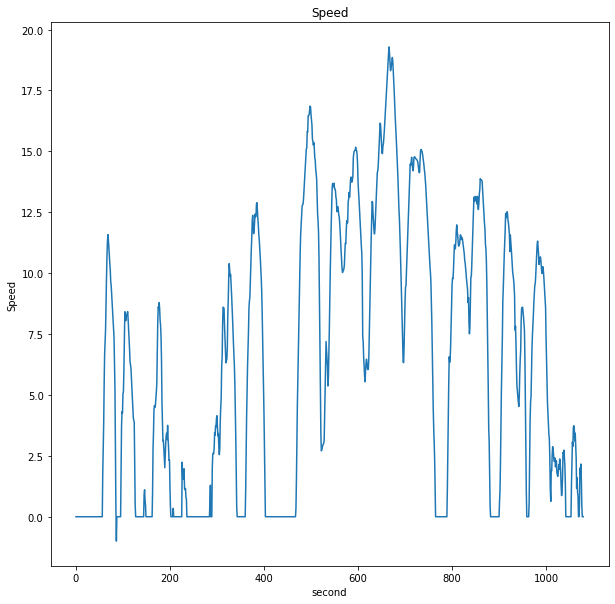

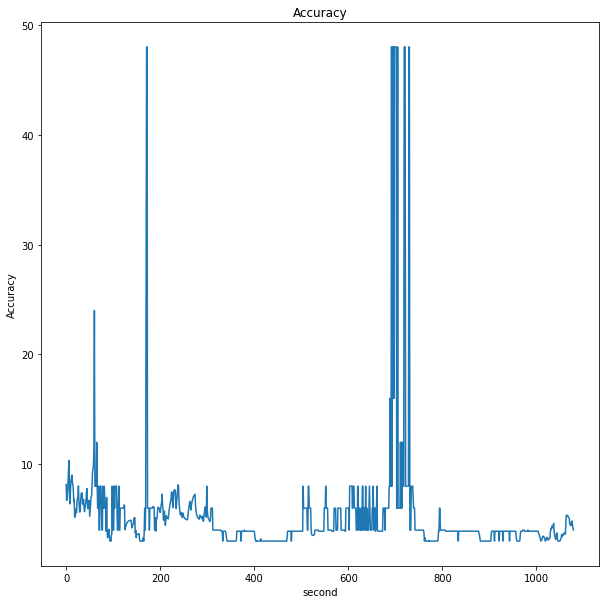

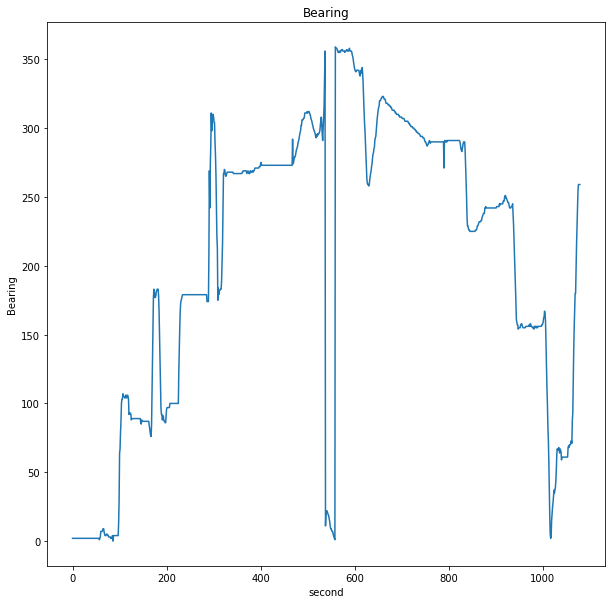

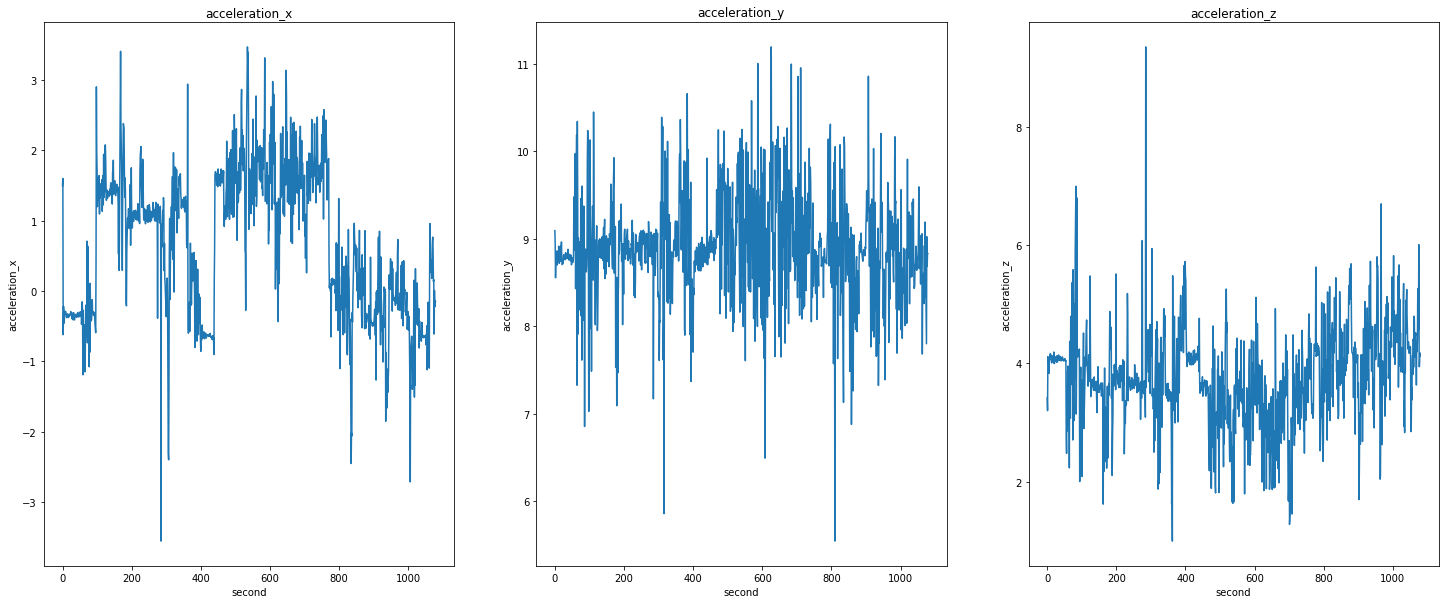

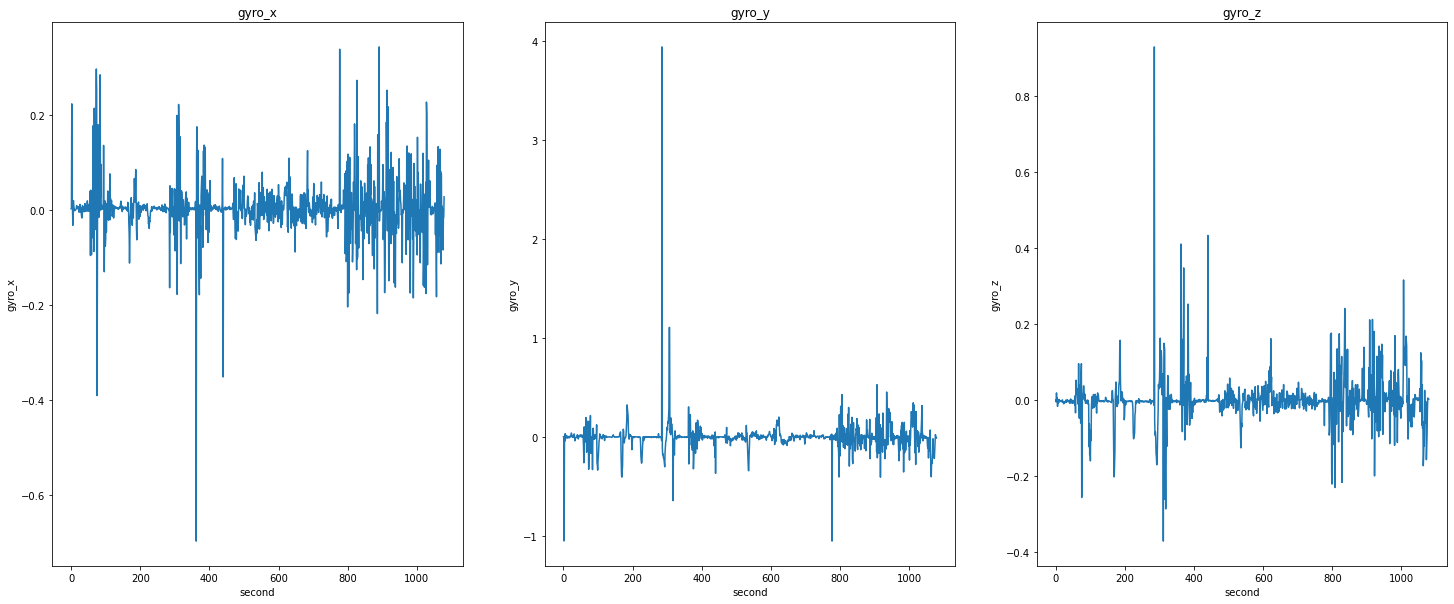

In [ ]:
# Looking at data for just 1 trip to see how it is like
# Taking a safe trip
one_trip_data = ml_data[ml_data['bookingID'] == 1709396983971]
display(one_trip_data)
display(one_trip_data.describe())

one_trip_data['second'].values

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x='second', y='Speed', data=one_trip_data, ax=ax)
ax.set_title('Speed')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x='second', y='Accuracy', data=one_trip_data, ax=ax)
ax.set_title('Accuracy')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(x='second', y='Bearing', data=one_trip_data, ax=ax)
ax.set_title('Bearing')

accs = ['acceleration_x', 'acceleration_y', 'acceleration_z']
gyros = ['gyro_x', 'gyro_y', 'gyro_z']

fig, ax = plt.subplots(1, 3, figsize=(25, 10))
for acc, axes in zip(accs, ax):
  sns.lineplot(x='second', y=acc, data=one_trip_data, ax=axes)
  axes.set_title(acc)

fig, ax = plt.subplots(1, 3, figsize=(25, 10))
for gyro, axes in zip(gyros, ax):
  sns.lineplot(x='second', y=gyro, data=one_trip_data, ax=axes)
  axes.set_title(gyro)
  

# Few peculair things
# The seconds don't match up 1003 data points -> 1589 second? Some are missing

## Moving on to gyro data

From the previous section, some of the larger outliers do not make sense. (80rad/s -> 20 rotations/s)

We will be removing these outliers

In [ ]:
# Looking more closely at the quantiles looking at 99 percent
display(ml_data[[f'gyro_{i}' for i in ['x', 'y', 'z']]].quantile(0.999))
display(ml_data[[f'gyro_{i}' for i in ['x', 'y', 'z']]].quantile(0.001))
# Looking at how many values outside this range
print(ml_data.shape[0] * (1- 0.999))

q_999 = ml_data[[f'gyro_{i}' for i in ['x', 'y', 'z']]].quantile(0.999).values
q_001 = ml_data[[f'gyro_{i}' for i in ['x', 'y', 'z']]].quantile(0.001).values

# q_999 = ml_data[[f'acceleration_{i}' for i in ['x', 'y', 'z']]].quantile(0.99).values
# q_001 = ml_data[[f'acceleration_{i}' for i in ['x', 'y', 'z']]].quantile(0.01).values
mask = None
for i, q999, q001 in zip(['x', 'y', 'z'], q_999, q_001):
  if mask is None:
    mask = ml_data[f'gyro_{i}'] > q999
    mask = mask | (ml_data[f'gyro_{i}'] < q001)
  else:
    mask = mask | (ml_data[f'gyro_{i}'] > q999)
    mask = mask | (ml_data[f'gyro_{i}'] < q001)

mask.value_counts()
ml_data = ml_data[~mask]
ml_data


gyro_x    0.769237
gyro_y    1.902563
gyro_z    0.838746
Name: 0.999, dtype: float64

gyro_x   -0.779287
gyro_y   -1.666693
gyro_z   -0.741027
Name: 0.001, dtype: float64

15229.957000000013


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,acc_vec,acc_y
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0,10.176551,9.941461
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0,10.059553,9.835590
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0,9.503762,9.270792
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0,9.830320,9.548032
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0,9.967466,9.853534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16154413,1709396983975,8.0,199.547104,-0.320905,-8.949738,-3.971979,-0.012879,0.015905,-0.007625,559.0,1.035811,1,9.796805,8.949738
16154414,1709396983975,8.0,199.547104,-0.418253,-8.929102,-3.950296,-0.006455,0.005278,-0.000082,560.0,1.035811,1,9.772852,8.929102
16154415,1709396983975,12.0,199.547104,-0.226697,-8.914597,-4.338940,0.044719,0.032351,-0.018600,561.0,0.302453,1,9.917047,8.914597
16154416,1709396983975,12.0,199.547104,-0.372943,-8.951382,-4.416550,0.053263,0.029213,-0.016357,562.0,0.302453,1,9.988606,8.951382


In [ ]:
ml_data[[f'gyro_{i}' for i in ['x', 'y', 'z']]].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,gyro_x,gyro_y,gyro_z
count,15161685.00000,15161685.00000,15161685.00000
mean,-0.00175,-0.00013,-0.00033
std,0.08813,0.12357,0.06526
min,-0.77929,-1.66669,-0.74103
25%,-0.02573,-0.02886,-0.01809
50%,-0.00067,0.00025,-0.00004
75%,0.02231,0.03015,0.01752
max,0.76922,1.90233,0.83875


## Looking at weird speed values

The weird values are the negative speed values.

In [ ]:
mask = ml_data['Speed'] < 0
ml_data[mask]['Speed'].value_counts()
# It seems like a majority of the negative values are -1
# This is likely a malfunction on the device
# We are going to change these values ot 0

-1.000000    187316
-0.018393         1
-0.003824         1
-0.143355         1
-0.197716         1
              ...  
-0.072229         1
-0.171874         1
-0.171091         1
-0.072464         1
-0.104879         1
Name: Speed, Length: 3106, dtype: int64

In [ ]:
mask = ml_data['Speed'] == -1
ml_data.loc[mask]['Speed'] = 0
ml_data['Speed'].describe().apply(lambda x: format(x, 'f'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    15161685.000000
mean            8.967714
std             8.099042
min            -1.719776
25%             0.990000
50%             7.459117
75%            15.434342
max           148.018630
Name: Speed, dtype: object

## Making the final datasets

In [ ]:
dl_data = ml_data
dl_data = dl_data.drop([f'acceleration_{i}' for i in ['x', 'y', 'z']], axis=1)

In [ ]:
display(ml_data)
display(ml_data.describe().apply(lambda s: s.apply('{0:.5f}'.format)))
display(dl_data)
display(dl_data.describe().apply(lambda s: s.apply('{0:.5f}'.format)))

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,acc_vec,acc_y
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0,10.176551,9.941461
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0,10.059553,9.835590
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0,9.503762,9.270792
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0,9.830320,9.548032
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0,9.967466,9.853534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15161680,1709396983975,8.0,199.547104,-0.320905,-8.949738,-3.971979,-0.012879,0.015905,-0.007625,559.0,1.035811,1,9.796805,8.949738
15161681,1709396983975,8.0,199.547104,-0.418253,-8.929102,-3.950296,-0.006455,0.005278,-0.000082,560.0,1.035811,1,9.772852,8.929102
15161682,1709396983975,12.0,199.547104,-0.226697,-8.914597,-4.338940,0.044719,0.032351,-0.018600,561.0,0.302453,1,9.917047,8.914597
15161683,1709396983975,12.0,199.547104,-0.372943,-8.951382,-4.416550,0.053263,0.029213,-0.016357,562.0,0.302453,1,9.988606,8.951382


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,acc_vec,acc_y
count,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000
mean,818246121411.68689,10.89137,168.75781,0.06285,4.66325,0.89650,-0.00175,-0.00013,-0.00033,4005.51488,8.96771,0.29758,9.79696,9.21533
std,494946986317.07629,82.51813,107.36156,1.00720,8.03398,2.87831,0.08813,0.12357,0.06526,1482109.32903,8.09904,0.45719,0.64581,1.16979
min,0.00000,0.75000,0.00000,-3.68958,-10.71382,-8.11592,-0.77929,-1.66669,-0.74103,0.00000,-1.71978,0.00000,0.00786,0.00000
25%,377957122225.00000,3.90000,78.00000,-0.48604,1.30249,-0.87432,-0.02573,-0.02886,-0.01809,240.00000,0.99000,0.00000,9.53582,8.89576
50%,807453851680.00000,4.00000,168.02567,0.06045,9.14374,0.78293,-0.00067,0.00025,-0.00004,517.00000,7.45912,0.00000,9.80589,9.47099
75%,1254130450445.00000,8.00000,262.25410,0.61200,9.71597,2.68398,0.02231,0.03015,0.01752,858.00000,15.43434,1.00000,10.09148,9.81361
max,1709396983975.00000,6070.10100,359.99948,3.97928,11.39951,9.59386,0.76922,1.90233,0.83875,1495796757.00000,148.01863,1.00000,15.13824,11.39951


,bookingID,Accuracy,Bearing,gyro_x,gyro_y,gyro_z,second,Speed,label,acc_vec,acc_y
0,0,12.0,143.298294,-0.016245,-0.094040,0.070732,0.0,3.442991,0,10.176551,9.941461
1,0,8.0,143.298294,-0.047092,-0.078874,0.043187,1.0,0.228454,0,10.059553,9.835590
2,0,8.0,143.298294,-0.028965,-0.032652,0.015390,2.0,0.228454,0,9.503762,9.270792
3,0,8.0,143.298294,-0.022413,0.005049,-0.025753,3.0,0.228454,0,9.830320,9.548032
4,0,8.0,143.298294,-0.014297,-0.046206,0.021902,4.0,0.228454,0,9.967466,9.853534
...,...,...,...,...,...,...,...,...,...,...,...
15161680,1709396983975,8.0,199.547104,-0.012879,0.015905,-0.007625,559.0,1.035811,1,9.796805,8.949738
15161681,1709396983975,8.0,199.547104,-0.006455,0.005278,-0.000082,560.0,1.035811,1,9.772852,8.929102
15161682,1709396983975,12.0,199.547104,0.044719,0.032351,-0.018600,561.0,0.302453,1,9.917047,8.914597
15161683,1709396983975,12.0,199.547104,0.053263,0.029213,-0.016357,562.0,0.302453,1,9.988606,8.951382


,bookingID,Accuracy,Bearing,gyro_x,gyro_y,gyro_z,second,Speed,label,acc_vec,acc_y
count,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000,15161685.00000
mean,818246121411.68689,10.89137,168.75781,-0.00175,-0.00013,-0.00033,4005.51488,8.96771,0.29758,9.79696,9.21533
std,494946986317.07629,82.51813,107.36156,0.08813,0.12357,0.06526,1482109.32903,8.09904,0.45719,0.64581,1.16979
min,0.00000,0.75000,0.00000,-0.77929,-1.66669,-0.74103,0.00000,-1.71978,0.00000,0.00786,0.00000
25%,377957122225.00000,3.90000,78.00000,-0.02573,-0.02886,-0.01809,240.00000,0.99000,0.00000,9.53582,8.89576
50%,807453851680.00000,4.00000,168.02567,-0.00067,0.00025,-0.00004,517.00000,7.45912,0.00000,9.80589,9.47099
75%,1254130450445.00000,8.00000,262.25410,0.02231,0.03015,0.01752,858.00000,15.43434,1.00000,10.09148,9.81361
max,1709396983975.00000,6070.10100,359.99948,0.76922,1.90233,0.83875,1495796757.00000,148.01863,1.00000,15.13824,11.39951


In [ ]:
# save the final data
ml_data.to_csv('/content/drive/MyDrive/grab/ml_data.csv', index=False)
dl_data.to_csv('/content/drive/MyDrive/grab/dl_data.csv', index=False)